In [1]:
import os
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import operator
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()
import pickle
import gc

#------------------------------------------------------------------------#
import re #regular expression/pattern matching
import random
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

C:\Users\amsha\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amsha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amsha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amsha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\amsha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\amsha\AppData\Roaming\

True

In [2]:
train_df = pd.read_csv("train_clean1.csv", encoding='utf8')
test_df = pd.read_csv("test_clean1.csv", encoding='utf8')
all_test_texts = ''.join(test_df.question_text.values.tolist())

print('Train:', train_df.shape)
print('Test:', test_df.shape)

Train: (1306122, 4)
Test: (375806, 3)


In [3]:
def remove_non_english_words(sent):
    sent = " ".join(w for w in nltk.wordpunct_tokenize(sent) \
             if w.lower() in words or not w.isalpha())
    return sent

words = set(nltk.corpus.words.words())

X_train = train_df['clean_question_text']
y_train = train_df['target']
X_test = test_df['clean_question_text']

# Check for Null values and fill them so that Vectorizer works fine
print("Total number of row with NaN values")
print(len(X_train[X_train.isnull()]))
X_train = X_train.fillna("_na_")
print("After Filing Null values")
print(X_train[X_train.isnull()])

print("Total number of row with NaN values")
print(len(X_test[X_test.isnull()]))
X_test = X_test.fillna("_na_")
print("After Filing Null values")
print(X_test[X_test.isnull()])

X_test = X_test.apply(lambda x: remove_non_english_words(x))
X_train = X_train.apply(lambda x: remove_non_english_words(x))

Total number of row with NaN values
85
After Filing Null values
Series([], Name: clean_question_text, dtype: object)
Total number of row with NaN values
37
After Filing Null values
Series([], Name: clean_question_text, dtype: object)


In [4]:
test_df['clean_question_text'] = X_test
train_df['clean_question_text'] = X_train

In [5]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float16')
    
    if file == 'wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    elif file == 'GoogleNews-vectors-negative300.bin':
        embeddings_index = KeyedVectors.load_word2vec_format(file, binary=True)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [6]:
glove = 'glove.840B.300d.txt'
paragram =  'paragram_300_sl999.txt'
google_path = 'GoogleNews-vectors-negative300.bin'
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)
print("Extracting Paragram embedding")
embed_paragram = load_embed(paragram)
print("Extracting GoogleNews embedding")
embed_google = load_embed(google_path)

Extracting GloVe embedding
Extracting Paragram embedding
Extracting GoogleNews embedding


C:\Users\amsha\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        if word in embeddings_index:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        elif word.capitalize() in embeddings_index:
            known_words[word] = embeddings_index[word.capitalize()]
            nb_known_words += vocab[word]
        elif word.lower() in embeddings_index:
            known_words[word] = embeddings_index[word.lower()]
            nb_known_words += vocab[word]
        elif word.upper() in embeddings_index:
            known_words[word] = embeddings_index[word.upper()]
            nb_known_words += vocab[word]
        else:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

def vocab_check_coverage(train_df, test_df):
    df = pd.concat([train_df.drop('target', axis=1), test_df]).reset_index(drop=True)
    
    vocab = build_vocab(df['clean_question_text'])
    print("Glove : ")
    oov_glove = check_coverage(vocab, embed_glove)
    oov_glove = {"oov_rate": len(oov_glove) / len(vocab), 'oov_words': oov_glove}
    print("Paragram : ")
    oov_paragram = check_coverage(vocab, embed_paragram)
    oov_paragram = {"oov_rate": len(oov_paragram) / len(vocab), 'oov_words': oov_paragram}
    print("Google : ")
    oov_google = check_coverage(vocab, embed_google)
    oov_google = {"oov_rate": len(oov_google) / len(vocab), 'oov_words': oov_google}
    
    return oov_glove, oov_paragram, oov_google

# Original Word Coverage

In [8]:
oov_glove, oov_paragram, oov_google = vocab_check_coverage(train_df, test_df)

Glove : 
Found embeddings for 87.63% of vocab
Found embeddings for  99.89% of all text
Paragram : 
Found embeddings for 87.93% of vocab
Found embeddings for  99.90% of all text
Google : 
Found embeddings for 80.53% of vocab
Found embeddings for  99.79% of all text


In [9]:
print('glove oov rate:', oov_glove['oov_rate'])
print('paragram oov rate:', oov_paragram['oov_rate'])
print('google oov rate:', oov_google['oov_rate'])

glove oov rate: 0.12371350556605755
paragram oov rate: 0.12073093887838689
google oov rate: 0.194664986347406


# Remarks
- The data is already cleaned so we got quite good % of words in the embedding
- Out of Vocabulory OOV is very low and coverage is very high. So we can continue to do our neural network

# CNN model 

Defining features of CNN model

In [10]:
max_features = 40000
maxlen = 70
embed_size = 300
threshold = 0.35
filter_sizes = [1,2,3]
num_filters = 42

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.metrics import precision_recall_curve
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn.metrics import f1_score
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

Using TensorFlow backend.


**Tokenization** 

Before applying the CNN model, we need to vectorize our text to feed the model

In [12]:
# initializing the Tokenizer 
tokenizer = text.Tokenizer(num_words=max_features)
#Train it for whole Vocab
tokenizer.fit_on_texts(list(X_train) + list(X_test))
#Turn the tokenizer in Sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
#Pad the sequences to the max length
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [13]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embed_glove.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

# Build The Model

In [15]:
filter_sizes = [1,2,3]
num_filters = 40
from keras.layers import Conv1D, MaxPool1D, BatchNormalization

def buildCNN():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, 300, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    
    conv1 = Conv1D(num_filters, kernel_size=(filter_sizes[0]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv2 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv3 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), 
                                 kernel_initializer='he_normal', activation='elu')(x)
    
    maxpool1 = MaxPool1D(pool_size=(maxlen - filter_sizes[0] + 1))(conv1)
    maxpool2 = MaxPool1D(pool_size=(maxlen - filter_sizes[1] + 1))(conv2)
    maxpool3 = MaxPool1D(pool_size=(maxlen - filter_sizes[2] + 1))(conv3)
        
    z = Concatenate(axis=1)([maxpool1, maxpool2, maxpool3])   
    z = Flatten()(z)
    z = BatchNormalization()(z)
        
    output = Dense(1, activation="sigmoid")(z)
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

model = buildCNN()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 300)      12000000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 70, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 70, 40)       12040       spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv1d_5 (

In [21]:
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.70,random_state=20)

C:\Users\amsha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [40]:
epoch_runs = model.fit(X_tra, y_tra, batch_size=1024, epochs=10,
                 validation_data=(X_val, y_val),verbose=True)

Instructions for updating:
Use tf.cast instead.
Train on 914285 samples, validate on 391837 samples
Epoch 1/10


208896/914285 [=====>........................] - ETA: 59:06 - loss: 0.8666 - acc: 0.50 - ETA: 37:15 - loss: 0.8461 - acc: 0.51 - ETA: 30:21 - loss: 0.8270 - acc: 0.51 - ETA: 26:44 - loss: 0.8194 - acc: 0.52 - ETA: 24:29 - loss: 0.8094 - acc: 0.53 - ETA: 23:00 - loss: 0.7978 - acc: 0.54 - ETA: 21:58 - loss: 0.7869 - acc: 0.55 - ETA: 21:21 - loss: 0.7810 - acc: 0.55 - ETA: 20:46 - loss: 0.7732 - acc: 0.56 - ETA: 20:13 - loss: 0.7666 - acc: 0.56 - ETA: 19:45 - loss: 0.7602 - acc: 0.57 - ETA: 19:25 - loss: 0.7549 - acc: 0.57 - ETA: 19:08 - loss: 0.7480 - acc: 0.57 - ETA: 18:52 - loss: 0.7436 - acc: 0.57 - ETA: 18:39 - loss: 0.7383 - acc: 0.58 - ETA: 18:24 - loss: 0.7337 - acc: 0.58 - ETA: 18:15 - loss: 0.7286 - acc: 0.58 - ETA: 18:08 - loss: 0.7236 - acc: 0.59 - ETA: 18:00 - loss: 0.7188 - acc: 0.59 - ETA: 17:53 - loss: 0.7141 - acc: 0.59 - ETA: 17:45 - loss: 0.7101 - acc: 0.60 - ETA: 17:40 - loss: 0.7061 - acc: 0.60 - ETA: 17:34 - loss: 0.7018 - acc: 0.60 - ETA: 17:28 - loss: 0.6977 - acc

626688/914285 [===================>..........] - ETA: 8:51 - loss: 0.2549 - acc: 0.902 - ETA: 8:50 - loss: 0.2546 - acc: 0.902 - ETA: 8:49 - loss: 0.2544 - acc: 0.902 - ETA: 8:47 - loss: 0.2542 - acc: 0.902 - ETA: 8:46 - loss: 0.2539 - acc: 0.902 - ETA: 8:45 - loss: 0.2537 - acc: 0.902 - ETA: 8:44 - loss: 0.2534 - acc: 0.902 - ETA: 8:43 - loss: 0.2532 - acc: 0.902 - ETA: 8:42 - loss: 0.2530 - acc: 0.902 - ETA: 8:41 - loss: 0.2528 - acc: 0.902 - ETA: 8:40 - loss: 0.2525 - acc: 0.903 - ETA: 8:39 - loss: 0.2523 - acc: 0.903 - ETA: 8:38 - loss: 0.2520 - acc: 0.903 - ETA: 8:36 - loss: 0.2518 - acc: 0.903 - ETA: 8:35 - loss: 0.2516 - acc: 0.903 - ETA: 8:34 - loss: 0.2514 - acc: 0.903 - ETA: 8:33 - loss: 0.2511 - acc: 0.903 - ETA: 8:32 - loss: 0.2509 - acc: 0.903 - ETA: 8:31 - loss: 0.2507 - acc: 0.903 - ETA: 8:30 - loss: 0.2505 - acc: 0.903 - ETA: 8:28 - loss: 0.2502 - acc: 0.903 - ETA: 8:27 - loss: 0.2500 - acc: 0.904 - ETA: 8:26 - loss: 0.2498 - acc: 0.904 - ETA: 8:25 - loss: 0.2497 - acc:

835584/914285 [==========================>...] - ETA: 5:07 - loss: 0.2213 - acc: 0.916 - ETA: 5:06 - loss: 0.2211 - acc: 0.916 - ETA: 5:05 - loss: 0.2210 - acc: 0.916 - ETA: 5:03 - loss: 0.2209 - acc: 0.916 - ETA: 5:02 - loss: 0.2208 - acc: 0.916 - ETA: 5:01 - loss: 0.2206 - acc: 0.916 - ETA: 5:00 - loss: 0.2205 - acc: 0.916 - ETA: 4:59 - loss: 0.2204 - acc: 0.916 - ETA: 4:58 - loss: 0.2203 - acc: 0.916 - ETA: 4:57 - loss: 0.2202 - acc: 0.916 - ETA: 4:56 - loss: 0.2201 - acc: 0.916 - ETA: 4:55 - loss: 0.2200 - acc: 0.916 - ETA: 4:54 - loss: 0.2199 - acc: 0.916 - ETA: 4:53 - loss: 0.2197 - acc: 0.916 - ETA: 4:51 - loss: 0.2196 - acc: 0.916 - ETA: 4:50 - loss: 0.2195 - acc: 0.916 - ETA: 4:49 - loss: 0.2194 - acc: 0.916 - ETA: 4:48 - loss: 0.2193 - acc: 0.916 - ETA: 4:47 - loss: 0.2193 - acc: 0.916 - ETA: 4:46 - loss: 0.2192 - acc: 0.917 - ETA: 4:45 - loss: 0.2191 - acc: 0.917 - ETA: 4:44 - loss: 0.2190 - acc: 0.917 - ETA: 4:43 - loss: 0.2188 - acc: 0.917 - ETA: 4:42 - loss: 0.2187 - acc:

914285/914285 [==============================] - ETA: 1:23 - loss: 0.2034 - acc: 0.923 - ETA: 1:22 - loss: 0.2033 - acc: 0.923 - ETA: 1:21 - loss: 0.2032 - acc: 0.923 - ETA: 1:20 - loss: 0.2032 - acc: 0.923 - ETA: 1:18 - loss: 0.2031 - acc: 0.923 - ETA: 1:17 - loss: 0.2030 - acc: 0.923 - ETA: 1:16 - loss: 0.2030 - acc: 0.923 - ETA: 1:15 - loss: 0.2028 - acc: 0.923 - ETA: 1:14 - loss: 0.2028 - acc: 0.923 - ETA: 1:13 - loss: 0.2027 - acc: 0.923 - ETA: 1:12 - loss: 0.2026 - acc: 0.923 - ETA: 1:11 - loss: 0.2025 - acc: 0.923 - ETA: 1:10 - loss: 0.2024 - acc: 0.923 - ETA: 1:09 - loss: 0.2024 - acc: 0.923 - ETA: 1:07 - loss: 0.2023 - acc: 0.923 - ETA: 1:06 - loss: 0.2022 - acc: 0.923 - ETA: 1:05 - loss: 0.2022 - acc: 0.923 - ETA: 1:04 - loss: 0.2021 - acc: 0.923 - ETA: 1:03 - loss: 0.2020 - acc: 0.923 - ETA: 1:02 - loss: 0.2020 - acc: 0.924 - ETA: 1:01 - loss: 0.2019 - acc: 0.924 - ETA: 1:00 - loss: 0.2018 - acc: 0.924 - ETA: 59s - loss: 0.2018 - acc: 0.924 - ETA: 58s - loss: 0.2017 - acc: 0

208896/914285 [=====>........................] - ETA: 19:31 - loss: 0.1387 - acc: 0.94 - ETA: 18:49 - loss: 0.1340 - acc: 0.95 - ETA: 18:42 - loss: 0.1377 - acc: 0.95 - ETA: 18:45 - loss: 0.1328 - acc: 0.95 - ETA: 18:39 - loss: 0.1353 - acc: 0.95 - ETA: 18:35 - loss: 0.1387 - acc: 0.94 - ETA: 18:24 - loss: 0.1409 - acc: 0.94 - ETA: 18:16 - loss: 0.1402 - acc: 0.94 - ETA: 18:13 - loss: 0.1384 - acc: 0.95 - ETA: 18:24 - loss: 0.1368 - acc: 0.95 - ETA: 18:23 - loss: 0.1357 - acc: 0.95 - ETA: 18:15 - loss: 0.1357 - acc: 0.95 - ETA: 18:12 - loss: 0.1364 - acc: 0.95 - ETA: 18:08 - loss: 0.1365 - acc: 0.95 - ETA: 18:05 - loss: 0.1371 - acc: 0.95 - ETA: 18:08 - loss: 0.1375 - acc: 0.94 - ETA: 18:10 - loss: 0.1365 - acc: 0.95 - ETA: 18:12 - loss: 0.1371 - acc: 0.94 - ETA: 18:09 - loss: 0.1383 - acc: 0.94 - ETA: 18:06 - loss: 0.1380 - acc: 0.94 - ETA: 18:08 - loss: 0.1375 - acc: 0.94 - ETA: 18:10 - loss: 0.1381 - acc: 0.94 - ETA: 18:13 - loss: 0.1386 - acc: 0.94 - ETA: 18:10 - loss: 0.1388 - acc

626688/914285 [===================>..........] - ETA: 17:02 - loss: 0.1393 - acc: 0.94 - ETA: 17:00 - loss: 0.1393 - acc: 0.94 - ETA: 16:58 - loss: 0.1393 - acc: 0.94 - ETA: 16:55 - loss: 0.1393 - acc: 0.94 - ETA: 16:54 - loss: 0.1393 - acc: 0.94 - ETA: 16:52 - loss: 0.1393 - acc: 0.94 - ETA: 16:50 - loss: 0.1393 - acc: 0.94 - ETA: 16:48 - loss: 0.1393 - acc: 0.94 - ETA: 16:46 - loss: 0.1394 - acc: 0.94 - ETA: 16:44 - loss: 0.1394 - acc: 0.94 - ETA: 16:42 - loss: 0.1393 - acc: 0.94 - ETA: 16:41 - loss: 0.1394 - acc: 0.94 - ETA: 16:39 - loss: 0.1393 - acc: 0.94 - ETA: 16:37 - loss: 0.1393 - acc: 0.94 - ETA: 16:35 - loss: 0.1393 - acc: 0.94 - ETA: 16:33 - loss: 0.1393 - acc: 0.94 - ETA: 16:31 - loss: 0.1393 - acc: 0.94 - ETA: 16:29 - loss: 0.1393 - acc: 0.94 - ETA: 16:27 - loss: 0.1393 - acc: 0.94 - ETA: 16:25 - loss: 0.1393 - acc: 0.94 - ETA: 16:23 - loss: 0.1394 - acc: 0.94 - ETA: 16:21 - loss: 0.1393 - acc: 0.94 - ETA: 16:19 - loss: 0.1393 - acc: 0.94 - ETA: 16:17 - loss: 0.1393 - acc

835584/914285 [==========================>...] - ETA: 9:31 - loss: 0.1393 - acc: 0.948 - ETA: 9:29 - loss: 0.1393 - acc: 0.948 - ETA: 9:27 - loss: 0.1393 - acc: 0.948 - ETA: 9:25 - loss: 0.1393 - acc: 0.948 - ETA: 9:22 - loss: 0.1392 - acc: 0.948 - ETA: 9:20 - loss: 0.1392 - acc: 0.948 - ETA: 9:18 - loss: 0.1392 - acc: 0.948 - ETA: 9:16 - loss: 0.1392 - acc: 0.948 - ETA: 9:14 - loss: 0.1392 - acc: 0.948 - ETA: 9:12 - loss: 0.1392 - acc: 0.948 - ETA: 9:10 - loss: 0.1392 - acc: 0.948 - ETA: 9:07 - loss: 0.1392 - acc: 0.948 - ETA: 9:05 - loss: 0.1392 - acc: 0.948 - ETA: 9:03 - loss: 0.1391 - acc: 0.948 - ETA: 9:01 - loss: 0.1391 - acc: 0.948 - ETA: 8:59 - loss: 0.1391 - acc: 0.948 - ETA: 8:57 - loss: 0.1391 - acc: 0.948 - ETA: 8:54 - loss: 0.1391 - acc: 0.948 - ETA: 8:52 - loss: 0.1391 - acc: 0.948 - ETA: 8:50 - loss: 0.1391 - acc: 0.948 - ETA: 8:48 - loss: 0.1391 - acc: 0.948 - ETA: 8:46 - loss: 0.1391 - acc: 0.948 - ETA: 8:44 - loss: 0.1391 - acc: 0.948 - ETA: 8:41 - loss: 0.1391 - acc:

914285/914285 [==============================] - ETA: 2:29 - loss: 0.1388 - acc: 0.948 - ETA: 2:27 - loss: 0.1388 - acc: 0.948 - ETA: 2:25 - loss: 0.1388 - acc: 0.948 - ETA: 2:23 - loss: 0.1389 - acc: 0.948 - ETA: 2:21 - loss: 0.1388 - acc: 0.948 - ETA: 2:19 - loss: 0.1388 - acc: 0.948 - ETA: 2:17 - loss: 0.1388 - acc: 0.948 - ETA: 2:15 - loss: 0.1388 - acc: 0.948 - ETA: 2:13 - loss: 0.1388 - acc: 0.948 - ETA: 2:11 - loss: 0.1388 - acc: 0.948 - ETA: 2:09 - loss: 0.1388 - acc: 0.948 - ETA: 2:07 - loss: 0.1388 - acc: 0.948 - ETA: 2:05 - loss: 0.1388 - acc: 0.948 - ETA: 2:04 - loss: 0.1388 - acc: 0.948 - ETA: 2:02 - loss: 0.1388 - acc: 0.948 - ETA: 2:00 - loss: 0.1388 - acc: 0.948 - ETA: 1:58 - loss: 0.1389 - acc: 0.948 - ETA: 1:56 - loss: 0.1389 - acc: 0.948 - ETA: 1:54 - loss: 0.1388 - acc: 0.948 - ETA: 1:52 - loss: 0.1388 - acc: 0.948 - ETA: 1:50 - loss: 0.1388 - acc: 0.948 - ETA: 1:48 - loss: 0.1388 - acc: 0.948 - ETA: 1:46 - loss: 0.1388 - acc: 0.948 - ETA: 1:44 - loss: 0.1388 - acc:

208896/914285 [=====>........................] - ETA: 28:08 - loss: 0.1269 - acc: 0.94 - ETA: 28:16 - loss: 0.1395 - acc: 0.94 - ETA: 28:45 - loss: 0.1438 - acc: 0.94 - ETA: 28:53 - loss: 0.1373 - acc: 0.94 - ETA: 28:39 - loss: 0.1373 - acc: 0.94 - ETA: 28:12 - loss: 0.1387 - acc: 0.94 - ETA: 27:58 - loss: 0.1371 - acc: 0.94 - ETA: 27:51 - loss: 0.1318 - acc: 0.95 - ETA: 27:33 - loss: 0.1323 - acc: 0.95 - ETA: 27:16 - loss: 0.1300 - acc: 0.95 - ETA: 27:02 - loss: 0.1305 - acc: 0.94 - ETA: 27:08 - loss: 0.1311 - acc: 0.94 - ETA: 27:05 - loss: 0.1281 - acc: 0.95 - ETA: 27:03 - loss: 0.1262 - acc: 0.95 - ETA: 26:57 - loss: 0.1263 - acc: 0.95 - ETA: 26:57 - loss: 0.1270 - acc: 0.95 - ETA: 26:49 - loss: 0.1267 - acc: 0.95 - ETA: 26:42 - loss: 0.1262 - acc: 0.95 - ETA: 26:37 - loss: 0.1276 - acc: 0.95 - ETA: 26:32 - loss: 0.1284 - acc: 0.95 - ETA: 26:30 - loss: 0.1293 - acc: 0.95 - ETA: 26:26 - loss: 0.1288 - acc: 0.95 - ETA: 26:21 - loss: 0.1284 - acc: 0.95 - ETA: 26:20 - loss: 0.1281 - acc

626688/914285 [===================>..........] - ETA: 14:35 - loss: 0.1297 - acc: 0.95 - ETA: 14:33 - loss: 0.1298 - acc: 0.95 - ETA: 14:32 - loss: 0.1298 - acc: 0.95 - ETA: 14:30 - loss: 0.1298 - acc: 0.95 - ETA: 14:28 - loss: 0.1298 - acc: 0.95 - ETA: 14:26 - loss: 0.1298 - acc: 0.95 - ETA: 14:24 - loss: 0.1298 - acc: 0.95 - ETA: 14:22 - loss: 0.1298 - acc: 0.95 - ETA: 14:20 - loss: 0.1299 - acc: 0.95 - ETA: 14:19 - loss: 0.1298 - acc: 0.95 - ETA: 14:17 - loss: 0.1298 - acc: 0.95 - ETA: 14:15 - loss: 0.1299 - acc: 0.95 - ETA: 14:13 - loss: 0.1299 - acc: 0.95 - ETA: 14:11 - loss: 0.1299 - acc: 0.95 - ETA: 14:09 - loss: 0.1299 - acc: 0.95 - ETA: 14:08 - loss: 0.1299 - acc: 0.95 - ETA: 14:06 - loss: 0.1299 - acc: 0.95 - ETA: 14:04 - loss: 0.1299 - acc: 0.95 - ETA: 14:03 - loss: 0.1299 - acc: 0.95 - ETA: 14:01 - loss: 0.1300 - acc: 0.95 - ETA: 13:59 - loss: 0.1300 - acc: 0.95 - ETA: 13:57 - loss: 0.1300 - acc: 0.95 - ETA: 13:56 - loss: 0.1300 - acc: 0.95 - ETA: 13:54 - loss: 0.1301 - acc

835584/914285 [==========================>...] - ETA: 8:26 - loss: 0.1309 - acc: 0.950 - ETA: 8:24 - loss: 0.1310 - acc: 0.950 - ETA: 8:23 - loss: 0.1310 - acc: 0.950 - ETA: 8:21 - loss: 0.1310 - acc: 0.950 - ETA: 8:19 - loss: 0.1311 - acc: 0.950 - ETA: 8:17 - loss: 0.1310 - acc: 0.950 - ETA: 8:15 - loss: 0.1310 - acc: 0.950 - ETA: 8:13 - loss: 0.1311 - acc: 0.950 - ETA: 8:12 - loss: 0.1311 - acc: 0.950 - ETA: 8:10 - loss: 0.1311 - acc: 0.950 - ETA: 8:08 - loss: 0.1310 - acc: 0.950 - ETA: 8:06 - loss: 0.1311 - acc: 0.950 - ETA: 8:04 - loss: 0.1310 - acc: 0.950 - ETA: 8:02 - loss: 0.1310 - acc: 0.950 - ETA: 8:01 - loss: 0.1310 - acc: 0.950 - ETA: 7:59 - loss: 0.1310 - acc: 0.950 - ETA: 7:57 - loss: 0.1310 - acc: 0.950 - ETA: 7:55 - loss: 0.1310 - acc: 0.950 - ETA: 7:54 - loss: 0.1310 - acc: 0.950 - ETA: 7:52 - loss: 0.1311 - acc: 0.950 - ETA: 7:50 - loss: 0.1310 - acc: 0.950 - ETA: 7:48 - loss: 0.1311 - acc: 0.950 - ETA: 7:46 - loss: 0.1310 - acc: 0.950 - ETA: 7:45 - loss: 0.1310 - acc:

914285/914285 [==============================] - ETA: 2:18 - loss: 0.1309 - acc: 0.950 - ETA: 2:16 - loss: 0.1309 - acc: 0.950 - ETA: 2:15 - loss: 0.1309 - acc: 0.950 - ETA: 2:13 - loss: 0.1309 - acc: 0.950 - ETA: 2:11 - loss: 0.1309 - acc: 0.950 - ETA: 2:09 - loss: 0.1309 - acc: 0.950 - ETA: 2:07 - loss: 0.1309 - acc: 0.950 - ETA: 2:05 - loss: 0.1309 - acc: 0.950 - ETA: 2:04 - loss: 0.1309 - acc: 0.950 - ETA: 2:02 - loss: 0.1309 - acc: 0.950 - ETA: 2:00 - loss: 0.1309 - acc: 0.950 - ETA: 1:58 - loss: 0.1309 - acc: 0.950 - ETA: 1:56 - loss: 0.1309 - acc: 0.950 - ETA: 1:55 - loss: 0.1309 - acc: 0.950 - ETA: 1:53 - loss: 0.1309 - acc: 0.950 - ETA: 1:51 - loss: 0.1309 - acc: 0.950 - ETA: 1:49 - loss: 0.1309 - acc: 0.950 - ETA: 1:47 - loss: 0.1309 - acc: 0.950 - ETA: 1:45 - loss: 0.1309 - acc: 0.950 - ETA: 1:44 - loss: 0.1309 - acc: 0.950 - ETA: 1:42 - loss: 0.1309 - acc: 0.950 - ETA: 1:40 - loss: 0.1308 - acc: 0.950 - ETA: 1:38 - loss: 0.1308 - acc: 0.950 - ETA: 1:36 - loss: 0.1308 - acc:

208896/914285 [=====>........................] - ETA: 27:28 - loss: 0.1312 - acc: 0.94 - ETA: 28:16 - loss: 0.1419 - acc: 0.94 - ETA: 28:26 - loss: 0.1381 - acc: 0.94 - ETA: 27:39 - loss: 0.1289 - acc: 0.95 - ETA: 27:59 - loss: 0.1258 - acc: 0.95 - ETA: 28:16 - loss: 0.1273 - acc: 0.95 - ETA: 27:59 - loss: 0.1262 - acc: 0.95 - ETA: 28:08 - loss: 0.1269 - acc: 0.95 - ETA: 28:15 - loss: 0.1269 - acc: 0.95 - ETA: 28:16 - loss: 0.1262 - acc: 0.95 - ETA: 28:08 - loss: 0.1271 - acc: 0.95 - ETA: 27:58 - loss: 0.1277 - acc: 0.95 - ETA: 27:52 - loss: 0.1269 - acc: 0.95 - ETA: 27:50 - loss: 0.1271 - acc: 0.95 - ETA: 27:45 - loss: 0.1269 - acc: 0.95 - ETA: 27:37 - loss: 0.1264 - acc: 0.95 - ETA: 27:24 - loss: 0.1274 - acc: 0.95 - ETA: 27:16 - loss: 0.1270 - acc: 0.95 - ETA: 27:07 - loss: 0.1274 - acc: 0.95 - ETA: 26:58 - loss: 0.1273 - acc: 0.95 - ETA: 26:51 - loss: 0.1271 - acc: 0.95 - ETA: 26:45 - loss: 0.1264 - acc: 0.95 - ETA: 26:42 - loss: 0.1266 - acc: 0.95 - ETA: 26:38 - loss: 0.1271 - acc

626688/914285 [===================>..........] - ETA: 13:27 - loss: 0.1245 - acc: 0.95 - ETA: 13:25 - loss: 0.1246 - acc: 0.95 - ETA: 13:22 - loss: 0.1245 - acc: 0.95 - ETA: 13:20 - loss: 0.1245 - acc: 0.95 - ETA: 13:17 - loss: 0.1245 - acc: 0.95 - ETA: 13:14 - loss: 0.1245 - acc: 0.95 - ETA: 13:12 - loss: 0.1246 - acc: 0.95 - ETA: 13:09 - loss: 0.1246 - acc: 0.95 - ETA: 13:07 - loss: 0.1247 - acc: 0.95 - ETA: 13:04 - loss: 0.1247 - acc: 0.95 - ETA: 13:02 - loss: 0.1247 - acc: 0.95 - ETA: 12:59 - loss: 0.1247 - acc: 0.95 - ETA: 12:57 - loss: 0.1247 - acc: 0.95 - ETA: 12:54 - loss: 0.1247 - acc: 0.95 - ETA: 12:52 - loss: 0.1247 - acc: 0.95 - ETA: 12:49 - loss: 0.1247 - acc: 0.95 - ETA: 12:47 - loss: 0.1247 - acc: 0.95 - ETA: 12:45 - loss: 0.1247 - acc: 0.95 - ETA: 12:42 - loss: 0.1247 - acc: 0.95 - ETA: 12:40 - loss: 0.1248 - acc: 0.95 - ETA: 12:37 - loss: 0.1248 - acc: 0.95 - ETA: 12:35 - loss: 0.1248 - acc: 0.95 - ETA: 12:32 - loss: 0.1248 - acc: 0.95 - ETA: 12:30 - loss: 0.1248 - acc

835584/914285 [==========================>...] - ETA: 6:36 - loss: 0.1247 - acc: 0.952 - ETA: 6:34 - loss: 0.1247 - acc: 0.952 - ETA: 6:33 - loss: 0.1248 - acc: 0.952 - ETA: 6:31 - loss: 0.1248 - acc: 0.952 - ETA: 6:29 - loss: 0.1248 - acc: 0.952 - ETA: 6:28 - loss: 0.1248 - acc: 0.952 - ETA: 6:26 - loss: 0.1248 - acc: 0.952 - ETA: 6:24 - loss: 0.1248 - acc: 0.952 - ETA: 6:23 - loss: 0.1248 - acc: 0.952 - ETA: 6:21 - loss: 0.1248 - acc: 0.952 - ETA: 6:19 - loss: 0.1248 - acc: 0.952 - ETA: 6:18 - loss: 0.1249 - acc: 0.952 - ETA: 6:16 - loss: 0.1248 - acc: 0.952 - ETA: 6:14 - loss: 0.1248 - acc: 0.952 - ETA: 6:13 - loss: 0.1248 - acc: 0.952 - ETA: 6:11 - loss: 0.1248 - acc: 0.952 - ETA: 6:10 - loss: 0.1249 - acc: 0.952 - ETA: 6:08 - loss: 0.1249 - acc: 0.952 - ETA: 6:06 - loss: 0.1248 - acc: 0.952 - ETA: 6:05 - loss: 0.1248 - acc: 0.952 - ETA: 6:03 - loss: 0.1248 - acc: 0.952 - ETA: 6:01 - loss: 0.1248 - acc: 0.952 - ETA: 6:00 - loss: 0.1248 - acc: 0.952 - ETA: 5:58 - loss: 0.1248 - acc:

914285/914285 [==============================] - ETA: 1:36 - loss: 0.1250 - acc: 0.952 - ETA: 1:35 - loss: 0.1250 - acc: 0.952 - ETA: 1:34 - loss: 0.1250 - acc: 0.952 - ETA: 1:32 - loss: 0.1250 - acc: 0.952 - ETA: 1:31 - loss: 0.1250 - acc: 0.952 - ETA: 1:30 - loss: 0.1250 - acc: 0.952 - ETA: 1:28 - loss: 0.1250 - acc: 0.952 - ETA: 1:27 - loss: 0.1250 - acc: 0.952 - ETA: 1:26 - loss: 0.1250 - acc: 0.952 - ETA: 1:25 - loss: 0.1250 - acc: 0.952 - ETA: 1:23 - loss: 0.1250 - acc: 0.952 - ETA: 1:22 - loss: 0.1250 - acc: 0.952 - ETA: 1:21 - loss: 0.1251 - acc: 0.952 - ETA: 1:19 - loss: 0.1251 - acc: 0.952 - ETA: 1:18 - loss: 0.1251 - acc: 0.952 - ETA: 1:17 - loss: 0.1251 - acc: 0.952 - ETA: 1:15 - loss: 0.1251 - acc: 0.952 - ETA: 1:14 - loss: 0.1251 - acc: 0.952 - ETA: 1:13 - loss: 0.1251 - acc: 0.952 - ETA: 1:12 - loss: 0.1251 - acc: 0.952 - ETA: 1:10 - loss: 0.1251 - acc: 0.952 - ETA: 1:09 - loss: 0.1250 - acc: 0.952 - ETA: 1:08 - loss: 0.1250 - acc: 0.952 - ETA: 1:06 - loss: 0.1251 - acc:

208896/914285 [=====>........................] - ETA: 13:49 - loss: 0.1018 - acc: 0.96 - ETA: 13:01 - loss: 0.1153 - acc: 0.95 - ETA: 12:50 - loss: 0.1232 - acc: 0.95 - ETA: 12:45 - loss: 0.1252 - acc: 0.95 - ETA: 12:39 - loss: 0.1229 - acc: 0.95 - ETA: 12:37 - loss: 0.1234 - acc: 0.95 - ETA: 12:36 - loss: 0.1238 - acc: 0.95 - ETA: 12:33 - loss: 0.1233 - acc: 0.95 - ETA: 12:30 - loss: 0.1235 - acc: 0.95 - ETA: 12:29 - loss: 0.1235 - acc: 0.95 - ETA: 12:27 - loss: 0.1232 - acc: 0.95 - ETA: 12:26 - loss: 0.1213 - acc: 0.95 - ETA: 12:25 - loss: 0.1205 - acc: 0.95 - ETA: 12:23 - loss: 0.1184 - acc: 0.95 - ETA: 12:22 - loss: 0.1183 - acc: 0.95 - ETA: 12:21 - loss: 0.1182 - acc: 0.95 - ETA: 12:20 - loss: 0.1181 - acc: 0.95 - ETA: 12:20 - loss: 0.1160 - acc: 0.95 - ETA: 12:21 - loss: 0.1150 - acc: 0.95 - ETA: 12:20 - loss: 0.1153 - acc: 0.95 - ETA: 12:19 - loss: 0.1150 - acc: 0.95 - ETA: 12:17 - loss: 0.1157 - acc: 0.95 - ETA: 12:16 - loss: 0.1155 - acc: 0.95 - ETA: 12:14 - loss: 0.1147 - acc

626688/914285 [===================>..........] - ETA: 6:52 - loss: 0.1179 - acc: 0.954 - ETA: 6:52 - loss: 0.1179 - acc: 0.954 - ETA: 6:51 - loss: 0.1178 - acc: 0.954 - ETA: 6:50 - loss: 0.1179 - acc: 0.954 - ETA: 6:49 - loss: 0.1179 - acc: 0.954 - ETA: 6:48 - loss: 0.1179 - acc: 0.954 - ETA: 6:48 - loss: 0.1179 - acc: 0.954 - ETA: 6:47 - loss: 0.1179 - acc: 0.954 - ETA: 6:46 - loss: 0.1179 - acc: 0.954 - ETA: 6:45 - loss: 0.1178 - acc: 0.954 - ETA: 6:44 - loss: 0.1178 - acc: 0.954 - ETA: 6:43 - loss: 0.1178 - acc: 0.954 - ETA: 6:42 - loss: 0.1179 - acc: 0.954 - ETA: 6:41 - loss: 0.1179 - acc: 0.954 - ETA: 6:41 - loss: 0.1179 - acc: 0.954 - ETA: 6:40 - loss: 0.1178 - acc: 0.954 - ETA: 6:39 - loss: 0.1179 - acc: 0.954 - ETA: 6:38 - loss: 0.1178 - acc: 0.954 - ETA: 6:37 - loss: 0.1178 - acc: 0.954 - ETA: 6:36 - loss: 0.1179 - acc: 0.954 - ETA: 6:35 - loss: 0.1179 - acc: 0.954 - ETA: 6:35 - loss: 0.1179 - acc: 0.954 - ETA: 6:34 - loss: 0.1179 - acc: 0.954 - ETA: 6:33 - loss: 0.1179 - acc:

835584/914285 [==========================>...] - ETA: 3:59 - loss: 0.1191 - acc: 0.954 - ETA: 3:58 - loss: 0.1191 - acc: 0.954 - ETA: 3:57 - loss: 0.1192 - acc: 0.954 - ETA: 3:56 - loss: 0.1192 - acc: 0.954 - ETA: 3:55 - loss: 0.1192 - acc: 0.954 - ETA: 3:55 - loss: 0.1192 - acc: 0.954 - ETA: 3:54 - loss: 0.1192 - acc: 0.954 - ETA: 3:53 - loss: 0.1192 - acc: 0.954 - ETA: 3:52 - loss: 0.1193 - acc: 0.954 - ETA: 3:51 - loss: 0.1193 - acc: 0.954 - ETA: 3:50 - loss: 0.1193 - acc: 0.954 - ETA: 3:49 - loss: 0.1193 - acc: 0.954 - ETA: 3:49 - loss: 0.1193 - acc: 0.954 - ETA: 3:48 - loss: 0.1193 - acc: 0.954 - ETA: 3:47 - loss: 0.1193 - acc: 0.954 - ETA: 3:46 - loss: 0.1193 - acc: 0.954 - ETA: 3:45 - loss: 0.1193 - acc: 0.954 - ETA: 3:44 - loss: 0.1193 - acc: 0.954 - ETA: 3:43 - loss: 0.1193 - acc: 0.954 - ETA: 3:43 - loss: 0.1193 - acc: 0.954 - ETA: 3:42 - loss: 0.1193 - acc: 0.954 - ETA: 3:41 - loss: 0.1193 - acc: 0.954 - ETA: 3:40 - loss: 0.1193 - acc: 0.954 - ETA: 3:39 - loss: 0.1193 - acc:

914285/914285 [==============================] - ETA: 1:04 - loss: 0.1204 - acc: 0.954 - ETA: 1:03 - loss: 0.1204 - acc: 0.954 - ETA: 1:03 - loss: 0.1204 - acc: 0.954 - ETA: 1:02 - loss: 0.1204 - acc: 0.954 - ETA: 1:01 - loss: 0.1204 - acc: 0.954 - ETA: 1:00 - loss: 0.1204 - acc: 0.954 - ETA: 59s - loss: 0.1204 - acc: 0.954 - ETA: 58s - loss: 0.1204 - acc: 0.95 - ETA: 57s - loss: 0.1204 - acc: 0.95 - ETA: 57s - loss: 0.1204 - acc: 0.95 - ETA: 56s - loss: 0.1204 - acc: 0.95 - ETA: 55s - loss: 0.1204 - acc: 0.95 - ETA: 54s - loss: 0.1204 - acc: 0.95 - ETA: 53s - loss: 0.1205 - acc: 0.95 - ETA: 52s - loss: 0.1205 - acc: 0.95 - ETA: 52s - loss: 0.1205 - acc: 0.95 - ETA: 51s - loss: 0.1205 - acc: 0.95 - ETA: 50s - loss: 0.1204 - acc: 0.95 - ETA: 49s - loss: 0.1204 - acc: 0.95 - ETA: 48s - loss: 0.1204 - acc: 0.95 - ETA: 47s - loss: 0.1204 - acc: 0.95 - ETA: 46s - loss: 0.1204 - acc: 0.95 - ETA: 46s - loss: 0.1204 - acc: 0.95 - ETA: 45s - loss: 0.1204 - acc: 0.95 - ETA: 44s - loss: 0.1204 - 

208896/914285 [=====>........................] - ETA: 13:35 - loss: 0.1134 - acc: 0.96 - ETA: 13:08 - loss: 0.1209 - acc: 0.95 - ETA: 12:52 - loss: 0.1297 - acc: 0.95 - ETA: 12:45 - loss: 0.1248 - acc: 0.95 - ETA: 12:39 - loss: 0.1220 - acc: 0.95 - ETA: 12:37 - loss: 0.1189 - acc: 0.95 - ETA: 12:36 - loss: 0.1170 - acc: 0.95 - ETA: 12:34 - loss: 0.1146 - acc: 0.95 - ETA: 12:32 - loss: 0.1132 - acc: 0.95 - ETA: 12:31 - loss: 0.1133 - acc: 0.95 - ETA: 12:28 - loss: 0.1144 - acc: 0.95 - ETA: 12:26 - loss: 0.1137 - acc: 0.95 - ETA: 12:24 - loss: 0.1130 - acc: 0.95 - ETA: 12:23 - loss: 0.1128 - acc: 0.95 - ETA: 12:21 - loss: 0.1112 - acc: 0.95 - ETA: 12:21 - loss: 0.1120 - acc: 0.95 - ETA: 12:22 - loss: 0.1115 - acc: 0.95 - ETA: 12:23 - loss: 0.1099 - acc: 0.95 - ETA: 12:23 - loss: 0.1093 - acc: 0.95 - ETA: 12:21 - loss: 0.1090 - acc: 0.95 - ETA: 12:22 - loss: 0.1097 - acc: 0.95 - ETA: 12:25 - loss: 0.1107 - acc: 0.95 - ETA: 12:24 - loss: 0.1106 - acc: 0.95 - ETA: 12:22 - loss: 0.1102 - acc

626688/914285 [===================>..........] - ETA: 6:52 - loss: 0.1156 - acc: 0.955 - ETA: 6:52 - loss: 0.1156 - acc: 0.955 - ETA: 6:51 - loss: 0.1155 - acc: 0.955 - ETA: 6:50 - loss: 0.1155 - acc: 0.955 - ETA: 6:49 - loss: 0.1155 - acc: 0.955 - ETA: 6:48 - loss: 0.1155 - acc: 0.955 - ETA: 6:47 - loss: 0.1155 - acc: 0.955 - ETA: 6:47 - loss: 0.1155 - acc: 0.955 - ETA: 6:46 - loss: 0.1155 - acc: 0.955 - ETA: 6:45 - loss: 0.1155 - acc: 0.955 - ETA: 6:44 - loss: 0.1155 - acc: 0.955 - ETA: 6:43 - loss: 0.1155 - acc: 0.955 - ETA: 6:42 - loss: 0.1155 - acc: 0.955 - ETA: 6:41 - loss: 0.1155 - acc: 0.955 - ETA: 6:41 - loss: 0.1155 - acc: 0.955 - ETA: 6:40 - loss: 0.1155 - acc: 0.955 - ETA: 6:39 - loss: 0.1155 - acc: 0.955 - ETA: 6:38 - loss: 0.1155 - acc: 0.955 - ETA: 6:37 - loss: 0.1155 - acc: 0.955 - ETA: 6:36 - loss: 0.1155 - acc: 0.955 - ETA: 6:35 - loss: 0.1155 - acc: 0.955 - ETA: 6:35 - loss: 0.1155 - acc: 0.955 - ETA: 6:34 - loss: 0.1155 - acc: 0.955 - ETA: 6:33 - loss: 0.1155 - acc:

835584/914285 [==========================>...] - ETA: 3:59 - loss: 0.1158 - acc: 0.955 - ETA: 3:58 - loss: 0.1158 - acc: 0.955 - ETA: 3:57 - loss: 0.1158 - acc: 0.955 - ETA: 3:56 - loss: 0.1158 - acc: 0.955 - ETA: 3:55 - loss: 0.1158 - acc: 0.955 - ETA: 3:54 - loss: 0.1157 - acc: 0.955 - ETA: 3:53 - loss: 0.1158 - acc: 0.955 - ETA: 3:53 - loss: 0.1157 - acc: 0.955 - ETA: 3:52 - loss: 0.1157 - acc: 0.955 - ETA: 3:51 - loss: 0.1157 - acc: 0.955 - ETA: 3:50 - loss: 0.1158 - acc: 0.955 - ETA: 3:49 - loss: 0.1157 - acc: 0.955 - ETA: 3:48 - loss: 0.1157 - acc: 0.955 - ETA: 3:47 - loss: 0.1157 - acc: 0.955 - ETA: 3:47 - loss: 0.1156 - acc: 0.955 - ETA: 3:46 - loss: 0.1156 - acc: 0.955 - ETA: 3:45 - loss: 0.1156 - acc: 0.955 - ETA: 3:44 - loss: 0.1155 - acc: 0.955 - ETA: 3:43 - loss: 0.1155 - acc: 0.955 - ETA: 3:42 - loss: 0.1155 - acc: 0.955 - ETA: 3:41 - loss: 0.1155 - acc: 0.955 - ETA: 3:41 - loss: 0.1155 - acc: 0.955 - ETA: 3:40 - loss: 0.1155 - acc: 0.955 - ETA: 3:39 - loss: 0.1155 - acc:

914285/914285 [==============================] - ETA: 1:04 - loss: 0.1160 - acc: 0.955 - ETA: 1:03 - loss: 0.1160 - acc: 0.955 - ETA: 1:03 - loss: 0.1160 - acc: 0.955 - ETA: 1:02 - loss: 0.1160 - acc: 0.955 - ETA: 1:01 - loss: 0.1160 - acc: 0.955 - ETA: 1:00 - loss: 0.1160 - acc: 0.955 - ETA: 59s - loss: 0.1160 - acc: 0.955 - ETA: 58s - loss: 0.1160 - acc: 0.95 - ETA: 57s - loss: 0.1160 - acc: 0.95 - ETA: 57s - loss: 0.1161 - acc: 0.95 - ETA: 56s - loss: 0.1160 - acc: 0.95 - ETA: 55s - loss: 0.1160 - acc: 0.95 - ETA: 54s - loss: 0.1161 - acc: 0.95 - ETA: 53s - loss: 0.1160 - acc: 0.95 - ETA: 52s - loss: 0.1161 - acc: 0.95 - ETA: 51s - loss: 0.1161 - acc: 0.95 - ETA: 51s - loss: 0.1161 - acc: 0.95 - ETA: 50s - loss: 0.1161 - acc: 0.95 - ETA: 49s - loss: 0.1161 - acc: 0.95 - ETA: 48s - loss: 0.1161 - acc: 0.95 - ETA: 47s - loss: 0.1161 - acc: 0.95 - ETA: 46s - loss: 0.1161 - acc: 0.95 - ETA: 45s - loss: 0.1160 - acc: 0.95 - ETA: 45s - loss: 0.1160 - acc: 0.95 - ETA: 44s - loss: 0.1161 - 

208896/914285 [=====>........................] - ETA: 13:26 - loss: 0.0970 - acc: 0.96 - ETA: 13:07 - loss: 0.1063 - acc: 0.95 - ETA: 12:48 - loss: 0.1097 - acc: 0.95 - ETA: 12:44 - loss: 0.1115 - acc: 0.95 - ETA: 12:41 - loss: 0.1115 - acc: 0.95 - ETA: 12:40 - loss: 0.1140 - acc: 0.95 - ETA: 12:41 - loss: 0.1155 - acc: 0.95 - ETA: 12:35 - loss: 0.1156 - acc: 0.95 - ETA: 12:32 - loss: 0.1163 - acc: 0.95 - ETA: 12:30 - loss: 0.1180 - acc: 0.95 - ETA: 12:28 - loss: 0.1183 - acc: 0.95 - ETA: 12:26 - loss: 0.1162 - acc: 0.95 - ETA: 12:24 - loss: 0.1158 - acc: 0.95 - ETA: 12:22 - loss: 0.1156 - acc: 0.95 - ETA: 12:20 - loss: 0.1154 - acc: 0.95 - ETA: 12:19 - loss: 0.1152 - acc: 0.95 - ETA: 12:21 - loss: 0.1151 - acc: 0.95 - ETA: 12:20 - loss: 0.1145 - acc: 0.95 - ETA: 12:20 - loss: 0.1145 - acc: 0.95 - ETA: 12:19 - loss: 0.1149 - acc: 0.95 - ETA: 12:17 - loss: 0.1144 - acc: 0.95 - ETA: 12:16 - loss: 0.1142 - acc: 0.95 - ETA: 12:15 - loss: 0.1146 - acc: 0.95 - ETA: 12:14 - loss: 0.1133 - acc

626688/914285 [===================>..........] - ETA: 6:55 - loss: 0.1101 - acc: 0.958 - ETA: 6:54 - loss: 0.1101 - acc: 0.958 - ETA: 6:53 - loss: 0.1101 - acc: 0.958 - ETA: 6:52 - loss: 0.1102 - acc: 0.958 - ETA: 6:51 - loss: 0.1101 - acc: 0.958 - ETA: 6:51 - loss: 0.1101 - acc: 0.958 - ETA: 6:50 - loss: 0.1101 - acc: 0.958 - ETA: 6:49 - loss: 0.1101 - acc: 0.958 - ETA: 6:48 - loss: 0.1102 - acc: 0.958 - ETA: 6:47 - loss: 0.1102 - acc: 0.958 - ETA: 6:46 - loss: 0.1102 - acc: 0.958 - ETA: 6:45 - loss: 0.1102 - acc: 0.958 - ETA: 6:44 - loss: 0.1102 - acc: 0.958 - ETA: 6:44 - loss: 0.1103 - acc: 0.958 - ETA: 6:43 - loss: 0.1103 - acc: 0.957 - ETA: 6:42 - loss: 0.1103 - acc: 0.958 - ETA: 6:41 - loss: 0.1103 - acc: 0.957 - ETA: 6:40 - loss: 0.1103 - acc: 0.957 - ETA: 6:39 - loss: 0.1103 - acc: 0.958 - ETA: 6:38 - loss: 0.1102 - acc: 0.958 - ETA: 6:38 - loss: 0.1103 - acc: 0.957 - ETA: 6:37 - loss: 0.1102 - acc: 0.958 - ETA: 6:36 - loss: 0.1102 - acc: 0.958 - ETA: 6:35 - loss: 0.1102 - acc:

835584/914285 [==========================>...] - ETA: 3:59 - loss: 0.1107 - acc: 0.957 - ETA: 3:59 - loss: 0.1108 - acc: 0.957 - ETA: 3:58 - loss: 0.1108 - acc: 0.957 - ETA: 3:57 - loss: 0.1107 - acc: 0.957 - ETA: 3:56 - loss: 0.1107 - acc: 0.957 - ETA: 3:55 - loss: 0.1108 - acc: 0.957 - ETA: 3:54 - loss: 0.1107 - acc: 0.957 - ETA: 3:53 - loss: 0.1107 - acc: 0.957 - ETA: 3:53 - loss: 0.1108 - acc: 0.957 - ETA: 3:52 - loss: 0.1108 - acc: 0.957 - ETA: 3:51 - loss: 0.1108 - acc: 0.957 - ETA: 3:50 - loss: 0.1108 - acc: 0.957 - ETA: 3:49 - loss: 0.1108 - acc: 0.957 - ETA: 3:48 - loss: 0.1108 - acc: 0.957 - ETA: 3:47 - loss: 0.1108 - acc: 0.957 - ETA: 3:47 - loss: 0.1108 - acc: 0.957 - ETA: 3:46 - loss: 0.1108 - acc: 0.957 - ETA: 3:45 - loss: 0.1109 - acc: 0.957 - ETA: 3:44 - loss: 0.1109 - acc: 0.957 - ETA: 3:43 - loss: 0.1109 - acc: 0.957 - ETA: 3:42 - loss: 0.1109 - acc: 0.957 - ETA: 3:41 - loss: 0.1109 - acc: 0.957 - ETA: 3:41 - loss: 0.1109 - acc: 0.957 - ETA: 3:40 - loss: 0.1108 - acc:

914285/914285 [==============================] - ETA: 1:04 - loss: 0.1113 - acc: 0.957 - ETA: 1:04 - loss: 0.1113 - acc: 0.957 - ETA: 1:03 - loss: 0.1113 - acc: 0.957 - ETA: 1:02 - loss: 0.1113 - acc: 0.957 - ETA: 1:01 - loss: 0.1113 - acc: 0.957 - ETA: 1:00 - loss: 0.1113 - acc: 0.957 - ETA: 59s - loss: 0.1113 - acc: 0.957 - ETA: 58s - loss: 0.1113 - acc: 0.95 - ETA: 58s - loss: 0.1113 - acc: 0.95 - ETA: 57s - loss: 0.1113 - acc: 0.95 - ETA: 56s - loss: 0.1113 - acc: 0.95 - ETA: 55s - loss: 0.1113 - acc: 0.95 - ETA: 54s - loss: 0.1113 - acc: 0.95 - ETA: 53s - loss: 0.1113 - acc: 0.95 - ETA: 52s - loss: 0.1113 - acc: 0.95 - ETA: 52s - loss: 0.1113 - acc: 0.95 - ETA: 51s - loss: 0.1113 - acc: 0.95 - ETA: 50s - loss: 0.1113 - acc: 0.95 - ETA: 49s - loss: 0.1113 - acc: 0.95 - ETA: 48s - loss: 0.1113 - acc: 0.95 - ETA: 47s - loss: 0.1113 - acc: 0.95 - ETA: 46s - loss: 0.1113 - acc: 0.95 - ETA: 46s - loss: 0.1113 - acc: 0.95 - ETA: 45s - loss: 0.1113 - acc: 0.95 - ETA: 44s - loss: 0.1112 - 

208896/914285 [=====>........................] - ETA: 13:40 - loss: 0.1039 - acc: 0.95 - ETA: 12:58 - loss: 0.0850 - acc: 0.96 - ETA: 12:48 - loss: 0.0967 - acc: 0.96 - ETA: 12:45 - loss: 0.1005 - acc: 0.96 - ETA: 12:41 - loss: 0.0985 - acc: 0.96 - ETA: 12:36 - loss: 0.1023 - acc: 0.96 - ETA: 12:36 - loss: 0.1041 - acc: 0.95 - ETA: 12:34 - loss: 0.1033 - acc: 0.96 - ETA: 12:34 - loss: 0.1019 - acc: 0.96 - ETA: 12:33 - loss: 0.1020 - acc: 0.96 - ETA: 12:30 - loss: 0.1008 - acc: 0.96 - ETA: 12:31 - loss: 0.1005 - acc: 0.96 - ETA: 12:28 - loss: 0.1018 - acc: 0.96 - ETA: 12:28 - loss: 0.1033 - acc: 0.96 - ETA: 12:29 - loss: 0.1032 - acc: 0.96 - ETA: 12:29 - loss: 0.1026 - acc: 0.96 - ETA: 12:30 - loss: 0.1022 - acc: 0.96 - ETA: 12:28 - loss: 0.1025 - acc: 0.96 - ETA: 12:27 - loss: 0.1023 - acc: 0.96 - ETA: 12:25 - loss: 0.1023 - acc: 0.96 - ETA: 12:23 - loss: 0.1021 - acc: 0.96 - ETA: 12:22 - loss: 0.1023 - acc: 0.96 - ETA: 12:23 - loss: 0.1022 - acc: 0.96 - ETA: 12:21 - loss: 0.1014 - acc

626688/914285 [===================>..........] - ETA: 6:54 - loss: 0.1060 - acc: 0.959 - ETA: 6:53 - loss: 0.1061 - acc: 0.959 - ETA: 6:52 - loss: 0.1061 - acc: 0.959 - ETA: 6:52 - loss: 0.1060 - acc: 0.959 - ETA: 6:51 - loss: 0.1061 - acc: 0.959 - ETA: 6:50 - loss: 0.1060 - acc: 0.959 - ETA: 6:49 - loss: 0.1060 - acc: 0.959 - ETA: 6:48 - loss: 0.1061 - acc: 0.959 - ETA: 6:47 - loss: 0.1061 - acc: 0.959 - ETA: 6:46 - loss: 0.1061 - acc: 0.959 - ETA: 6:45 - loss: 0.1061 - acc: 0.959 - ETA: 6:45 - loss: 0.1061 - acc: 0.959 - ETA: 6:44 - loss: 0.1061 - acc: 0.959 - ETA: 6:43 - loss: 0.1061 - acc: 0.959 - ETA: 6:42 - loss: 0.1061 - acc: 0.959 - ETA: 6:41 - loss: 0.1061 - acc: 0.959 - ETA: 6:40 - loss: 0.1061 - acc: 0.959 - ETA: 6:39 - loss: 0.1061 - acc: 0.959 - ETA: 6:39 - loss: 0.1061 - acc: 0.959 - ETA: 6:38 - loss: 0.1061 - acc: 0.959 - ETA: 6:37 - loss: 0.1061 - acc: 0.959 - ETA: 6:36 - loss: 0.1061 - acc: 0.959 - ETA: 6:35 - loss: 0.1062 - acc: 0.959 - ETA: 6:34 - loss: 0.1061 - acc:

835584/914285 [==========================>...] - ETA: 3:59 - loss: 0.1070 - acc: 0.959 - ETA: 3:58 - loss: 0.1070 - acc: 0.959 - ETA: 3:57 - loss: 0.1070 - acc: 0.959 - ETA: 3:57 - loss: 0.1070 - acc: 0.959 - ETA: 3:56 - loss: 0.1070 - acc: 0.959 - ETA: 3:55 - loss: 0.1070 - acc: 0.959 - ETA: 3:54 - loss: 0.1070 - acc: 0.959 - ETA: 3:53 - loss: 0.1070 - acc: 0.959 - ETA: 3:52 - loss: 0.1070 - acc: 0.959 - ETA: 3:51 - loss: 0.1070 - acc: 0.959 - ETA: 3:51 - loss: 0.1070 - acc: 0.959 - ETA: 3:50 - loss: 0.1070 - acc: 0.959 - ETA: 3:49 - loss: 0.1070 - acc: 0.959 - ETA: 3:48 - loss: 0.1070 - acc: 0.959 - ETA: 3:47 - loss: 0.1070 - acc: 0.958 - ETA: 3:46 - loss: 0.1070 - acc: 0.958 - ETA: 3:45 - loss: 0.1070 - acc: 0.958 - ETA: 3:45 - loss: 0.1071 - acc: 0.958 - ETA: 3:44 - loss: 0.1071 - acc: 0.959 - ETA: 3:43 - loss: 0.1071 - acc: 0.958 - ETA: 3:42 - loss: 0.1070 - acc: 0.959 - ETA: 3:41 - loss: 0.1070 - acc: 0.959 - ETA: 3:40 - loss: 0.1070 - acc: 0.959 - ETA: 3:40 - loss: 0.1070 - acc:

914285/914285 [==============================] - ETA: 1:04 - loss: 0.1073 - acc: 0.958 - ETA: 1:04 - loss: 0.1073 - acc: 0.958 - ETA: 1:03 - loss: 0.1073 - acc: 0.958 - ETA: 1:02 - loss: 0.1073 - acc: 0.958 - ETA: 1:01 - loss: 0.1073 - acc: 0.958 - ETA: 1:00 - loss: 0.1073 - acc: 0.958 - ETA: 59s - loss: 0.1073 - acc: 0.958 - ETA: 58s - loss: 0.1073 - acc: 0.95 - ETA: 58s - loss: 0.1072 - acc: 0.95 - ETA: 57s - loss: 0.1073 - acc: 0.95 - ETA: 56s - loss: 0.1073 - acc: 0.95 - ETA: 55s - loss: 0.1072 - acc: 0.95 - ETA: 54s - loss: 0.1072 - acc: 0.95 - ETA: 53s - loss: 0.1072 - acc: 0.95 - ETA: 52s - loss: 0.1072 - acc: 0.95 - ETA: 52s - loss: 0.1072 - acc: 0.95 - ETA: 51s - loss: 0.1072 - acc: 0.95 - ETA: 50s - loss: 0.1072 - acc: 0.95 - ETA: 49s - loss: 0.1072 - acc: 0.95 - ETA: 48s - loss: 0.1072 - acc: 0.95 - ETA: 47s - loss: 0.1072 - acc: 0.95 - ETA: 46s - loss: 0.1072 - acc: 0.95 - ETA: 46s - loss: 0.1072 - acc: 0.95 - ETA: 45s - loss: 0.1072 - acc: 0.95 - ETA: 44s - loss: 0.1072 - 

208896/914285 [=====>........................] - ETA: 13:41 - loss: 0.0964 - acc: 0.96 - ETA: 13:15 - loss: 0.0900 - acc: 0.96 - ETA: 12:54 - loss: 0.0965 - acc: 0.96 - ETA: 12:54 - loss: 0.0927 - acc: 0.96 - ETA: 12:50 - loss: 0.0947 - acc: 0.96 - ETA: 12:42 - loss: 0.0961 - acc: 0.96 - ETA: 12:41 - loss: 0.0962 - acc: 0.96 - ETA: 12:39 - loss: 0.0984 - acc: 0.96 - ETA: 12:39 - loss: 0.0981 - acc: 0.96 - ETA: 12:36 - loss: 0.0978 - acc: 0.96 - ETA: 12:35 - loss: 0.0976 - acc: 0.96 - ETA: 12:38 - loss: 0.0989 - acc: 0.96 - ETA: 12:39 - loss: 0.0974 - acc: 0.96 - ETA: 12:38 - loss: 0.0971 - acc: 0.96 - ETA: 12:36 - loss: 0.0961 - acc: 0.96 - ETA: 12:34 - loss: 0.0957 - acc: 0.96 - ETA: 12:32 - loss: 0.0962 - acc: 0.96 - ETA: 12:30 - loss: 0.0959 - acc: 0.96 - ETA: 12:28 - loss: 0.0956 - acc: 0.96 - ETA: 12:27 - loss: 0.0947 - acc: 0.96 - ETA: 12:25 - loss: 0.0938 - acc: 0.96 - ETA: 12:25 - loss: 0.0941 - acc: 0.96 - ETA: 12:24 - loss: 0.0943 - acc: 0.96 - ETA: 12:24 - loss: 0.0944 - acc

626688/914285 [===================>..........] - ETA: 6:53 - loss: 0.1015 - acc: 0.961 - ETA: 6:52 - loss: 0.1015 - acc: 0.961 - ETA: 6:51 - loss: 0.1015 - acc: 0.961 - ETA: 6:51 - loss: 0.1015 - acc: 0.961 - ETA: 6:50 - loss: 0.1015 - acc: 0.961 - ETA: 6:49 - loss: 0.1015 - acc: 0.961 - ETA: 6:48 - loss: 0.1015 - acc: 0.961 - ETA: 6:47 - loss: 0.1015 - acc: 0.961 - ETA: 6:46 - loss: 0.1015 - acc: 0.961 - ETA: 6:45 - loss: 0.1015 - acc: 0.961 - ETA: 6:45 - loss: 0.1015 - acc: 0.961 - ETA: 6:44 - loss: 0.1014 - acc: 0.961 - ETA: 6:43 - loss: 0.1015 - acc: 0.961 - ETA: 6:42 - loss: 0.1014 - acc: 0.961 - ETA: 6:41 - loss: 0.1014 - acc: 0.961 - ETA: 6:41 - loss: 0.1014 - acc: 0.961 - ETA: 6:40 - loss: 0.1014 - acc: 0.961 - ETA: 6:39 - loss: 0.1014 - acc: 0.961 - ETA: 6:38 - loss: 0.1014 - acc: 0.961 - ETA: 6:37 - loss: 0.1015 - acc: 0.961 - ETA: 6:36 - loss: 0.1015 - acc: 0.961 - ETA: 6:35 - loss: 0.1014 - acc: 0.961 - ETA: 6:35 - loss: 0.1015 - acc: 0.961 - ETA: 6:34 - loss: 0.1015 - acc:

835584/914285 [==========================>...] - ETA: 3:59 - loss: 0.1020 - acc: 0.961 - ETA: 3:58 - loss: 0.1020 - acc: 0.961 - ETA: 3:57 - loss: 0.1020 - acc: 0.961 - ETA: 3:56 - loss: 0.1020 - acc: 0.961 - ETA: 3:55 - loss: 0.1020 - acc: 0.961 - ETA: 3:54 - loss: 0.1020 - acc: 0.961 - ETA: 3:54 - loss: 0.1020 - acc: 0.961 - ETA: 3:53 - loss: 0.1020 - acc: 0.961 - ETA: 3:52 - loss: 0.1020 - acc: 0.961 - ETA: 3:51 - loss: 0.1020 - acc: 0.961 - ETA: 3:50 - loss: 0.1021 - acc: 0.961 - ETA: 3:49 - loss: 0.1021 - acc: 0.961 - ETA: 3:48 - loss: 0.1021 - acc: 0.961 - ETA: 3:48 - loss: 0.1021 - acc: 0.961 - ETA: 3:47 - loss: 0.1021 - acc: 0.961 - ETA: 3:46 - loss: 0.1020 - acc: 0.961 - ETA: 3:45 - loss: 0.1020 - acc: 0.961 - ETA: 3:44 - loss: 0.1021 - acc: 0.961 - ETA: 3:43 - loss: 0.1021 - acc: 0.961 - ETA: 3:43 - loss: 0.1021 - acc: 0.961 - ETA: 3:42 - loss: 0.1021 - acc: 0.961 - ETA: 3:41 - loss: 0.1021 - acc: 0.961 - ETA: 3:40 - loss: 0.1021 - acc: 0.961 - ETA: 3:39 - loss: 0.1021 - acc:

914285/914285 [==============================] - ETA: 1:05 - loss: 0.1025 - acc: 0.960 - ETA: 1:04 - loss: 0.1025 - acc: 0.960 - ETA: 1:03 - loss: 0.1025 - acc: 0.960 - ETA: 1:02 - loss: 0.1025 - acc: 0.960 - ETA: 1:01 - loss: 0.1025 - acc: 0.960 - ETA: 1:00 - loss: 0.1025 - acc: 0.960 - ETA: 59s - loss: 0.1025 - acc: 0.960 - ETA: 59s - loss: 0.1025 - acc: 0.96 - ETA: 58s - loss: 0.1025 - acc: 0.96 - ETA: 57s - loss: 0.1025 - acc: 0.96 - ETA: 56s - loss: 0.1025 - acc: 0.96 - ETA: 55s - loss: 0.1024 - acc: 0.96 - ETA: 54s - loss: 0.1024 - acc: 0.96 - ETA: 53s - loss: 0.1025 - acc: 0.96 - ETA: 53s - loss: 0.1025 - acc: 0.96 - ETA: 52s - loss: 0.1025 - acc: 0.96 - ETA: 51s - loss: 0.1025 - acc: 0.96 - ETA: 50s - loss: 0.1025 - acc: 0.96 - ETA: 49s - loss: 0.1025 - acc: 0.96 - ETA: 48s - loss: 0.1025 - acc: 0.96 - ETA: 47s - loss: 0.1025 - acc: 0.96 - ETA: 47s - loss: 0.1025 - acc: 0.96 - ETA: 46s - loss: 0.1025 - acc: 0.96 - ETA: 45s - loss: 0.1025 - acc: 0.96 - ETA: 44s - loss: 0.1025 - 

208896/914285 [=====>........................] - ETA: 13:27 - loss: 0.0820 - acc: 0.96 - ETA: 13:02 - loss: 0.0906 - acc: 0.96 - ETA: 12:55 - loss: 0.0933 - acc: 0.96 - ETA: 12:48 - loss: 0.0895 - acc: 0.96 - ETA: 12:51 - loss: 0.0958 - acc: 0.96 - ETA: 12:43 - loss: 0.0930 - acc: 0.96 - ETA: 12:44 - loss: 0.0944 - acc: 0.96 - ETA: 12:48 - loss: 0.0943 - acc: 0.96 - ETA: 12:42 - loss: 0.0922 - acc: 0.96 - ETA: 12:39 - loss: 0.0933 - acc: 0.96 - ETA: 12:36 - loss: 0.0925 - acc: 0.96 - ETA: 12:35 - loss: 0.0928 - acc: 0.96 - ETA: 12:35 - loss: 0.0936 - acc: 0.96 - ETA: 12:33 - loss: 0.0926 - acc: 0.96 - ETA: 12:31 - loss: 0.0947 - acc: 0.96 - ETA: 12:30 - loss: 0.0956 - acc: 0.96 - ETA: 12:28 - loss: 0.0959 - acc: 0.96 - ETA: 12:27 - loss: 0.0968 - acc: 0.96 - ETA: 12:25 - loss: 0.0964 - acc: 0.96 - ETA: 12:25 - loss: 0.0961 - acc: 0.96 - ETA: 12:25 - loss: 0.0957 - acc: 0.96 - ETA: 12:22 - loss: 0.0960 - acc: 0.96 - ETA: 12:21 - loss: 0.0960 - acc: 0.96 - ETA: 12:20 - loss: 0.0962 - acc

626688/914285 [===================>..........] - ETA: 6:54 - loss: 0.0970 - acc: 0.963 - ETA: 6:53 - loss: 0.0970 - acc: 0.963 - ETA: 6:53 - loss: 0.0970 - acc: 0.963 - ETA: 6:52 - loss: 0.0970 - acc: 0.963 - ETA: 6:51 - loss: 0.0971 - acc: 0.963 - ETA: 6:50 - loss: 0.0971 - acc: 0.963 - ETA: 6:49 - loss: 0.0971 - acc: 0.963 - ETA: 6:48 - loss: 0.0971 - acc: 0.963 - ETA: 6:47 - loss: 0.0971 - acc: 0.963 - ETA: 6:47 - loss: 0.0970 - acc: 0.963 - ETA: 6:46 - loss: 0.0971 - acc: 0.963 - ETA: 6:45 - loss: 0.0971 - acc: 0.963 - ETA: 6:44 - loss: 0.0970 - acc: 0.963 - ETA: 6:43 - loss: 0.0970 - acc: 0.963 - ETA: 6:42 - loss: 0.0970 - acc: 0.963 - ETA: 6:41 - loss: 0.0970 - acc: 0.963 - ETA: 6:40 - loss: 0.0969 - acc: 0.963 - ETA: 6:40 - loss: 0.0969 - acc: 0.963 - ETA: 6:39 - loss: 0.0969 - acc: 0.963 - ETA: 6:38 - loss: 0.0969 - acc: 0.963 - ETA: 6:37 - loss: 0.0969 - acc: 0.963 - ETA: 6:36 - loss: 0.0969 - acc: 0.963 - ETA: 6:35 - loss: 0.0969 - acc: 0.963 - ETA: 6:34 - loss: 0.0969 - acc:

835584/914285 [==========================>...] - ETA: 3:59 - loss: 0.0975 - acc: 0.962 - ETA: 3:58 - loss: 0.0975 - acc: 0.962 - ETA: 3:57 - loss: 0.0975 - acc: 0.962 - ETA: 3:57 - loss: 0.0975 - acc: 0.962 - ETA: 3:56 - loss: 0.0975 - acc: 0.962 - ETA: 3:55 - loss: 0.0975 - acc: 0.962 - ETA: 3:54 - loss: 0.0976 - acc: 0.962 - ETA: 3:53 - loss: 0.0975 - acc: 0.962 - ETA: 3:52 - loss: 0.0975 - acc: 0.962 - ETA: 3:51 - loss: 0.0975 - acc: 0.962 - ETA: 3:51 - loss: 0.0975 - acc: 0.962 - ETA: 3:50 - loss: 0.0975 - acc: 0.962 - ETA: 3:49 - loss: 0.0975 - acc: 0.962 - ETA: 3:48 - loss: 0.0975 - acc: 0.962 - ETA: 3:47 - loss: 0.0975 - acc: 0.962 - ETA: 3:46 - loss: 0.0975 - acc: 0.962 - ETA: 3:45 - loss: 0.0975 - acc: 0.962 - ETA: 3:45 - loss: 0.0975 - acc: 0.962 - ETA: 3:44 - loss: 0.0975 - acc: 0.962 - ETA: 3:43 - loss: 0.0975 - acc: 0.962 - ETA: 3:42 - loss: 0.0975 - acc: 0.962 - ETA: 3:41 - loss: 0.0975 - acc: 0.962 - ETA: 3:40 - loss: 0.0975 - acc: 0.962 - ETA: 3:39 - loss: 0.0975 - acc:

914285/914285 [==============================] - ETA: 1:05 - loss: 0.0982 - acc: 0.962 - ETA: 1:04 - loss: 0.0982 - acc: 0.962 - ETA: 1:03 - loss: 0.0982 - acc: 0.962 - ETA: 1:02 - loss: 0.0982 - acc: 0.962 - ETA: 1:01 - loss: 0.0983 - acc: 0.962 - ETA: 1:00 - loss: 0.0982 - acc: 0.962 - ETA: 59s - loss: 0.0982 - acc: 0.962 - ETA: 59s - loss: 0.0982 - acc: 0.96 - ETA: 58s - loss: 0.0983 - acc: 0.96 - ETA: 57s - loss: 0.0983 - acc: 0.96 - ETA: 56s - loss: 0.0982 - acc: 0.96 - ETA: 55s - loss: 0.0982 - acc: 0.96 - ETA: 54s - loss: 0.0982 - acc: 0.96 - ETA: 53s - loss: 0.0983 - acc: 0.96 - ETA: 53s - loss: 0.0983 - acc: 0.96 - ETA: 52s - loss: 0.0983 - acc: 0.96 - ETA: 51s - loss: 0.0982 - acc: 0.96 - ETA: 50s - loss: 0.0982 - acc: 0.96 - ETA: 49s - loss: 0.0982 - acc: 0.96 - ETA: 48s - loss: 0.0982 - acc: 0.96 - ETA: 47s - loss: 0.0982 - acc: 0.96 - ETA: 47s - loss: 0.0982 - acc: 0.96 - ETA: 46s - loss: 0.0982 - acc: 0.96 - ETA: 45s - loss: 0.0982 - acc: 0.96 - ETA: 44s - loss: 0.0982 - 

In [42]:
# # Pickle epoch_runs to local  computer
#dill: this is necessary in order for pickle to save epoch_runs .
import dill as pickled

save_epoch_runs = open("epoch_runs.pickle", 'wb') #wb= write in bytes. 'Tfidf_LogR.pickle' is the name of the file saved
pickled.dump(epoch_runs, save_epoch_runs) #use pickle to dump the grid1 we trained as 'Tfidf_LogR.pickle' in wb format
save_epoch_runs.close()  

In [44]:
save_model_cnn = open("model_cnn.pickle", 'wb') #wb= write in bytes. 'Tfidf_LogR.pickle' is the name of the file saved
pickled.dump(model, save_model_cnn) #use pickle to dump the grid1 we trained as 'Tfidf_LogR.pickle' in wb format
save_model_cnn.close()

In [43]:
# Retrieve the saved file and uplaod it to an object

save_epoch_runs1 = open("epoch_runs.pickle", 'rb') # rb= read in bytes
epoch_runs1 = pickled.load(save_epoch_runs1)
save_epoch_runs1.close()

In [46]:
# Retrieve the saved file and uplaod it to an object

save_model1 = open("model_cnn.pickle", 'rb') # rb= read in bytes
model1 = pickled.load(save_model1)
save_model1.close()

In [63]:
threshold = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = model.predict(X_val)
f1_scores = []

for t in threshold:
    y_pred = (predictions > t).astype(int)
    print ('threshold: ', t)
    print ('accuracy', accuracy_score(y_val, y_pred))
    print ('classification report:')
    print (classification_report(y_val, y_pred))
    print('F1 Score :', f1_score(y_val, y_pred))
    print ('======================')
    f1_scores.append(f1_score(y_val, y_pred))

threshold:  0.0001
accuracy 0.20005002079946507
classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26    367560
           1       0.07      1.00      0.13     24277

   micro avg       0.20      0.20      0.20    391837
   macro avg       0.54      0.57      0.20    391837
weighted avg       0.94      0.20      0.25    391837

F1 Score : 0.13392941020440868
threshold:  0.001
accuracy 0.45916797035502005
classification report:
              precision    recall  f1-score   support

           0       1.00      0.42      0.60    367560
           1       0.10      0.99      0.18     24277

   micro avg       0.46      0.46      0.46    391837
   macro avg       0.55      0.71      0.39    391837
weighted avg       0.94      0.46      0.57    391837

F1 Score : 0.1842216696051183
threshold:  0.01
accuracy 0.7515242307388021
classification report:
              precision    recall  f1-score   support

           0       0.

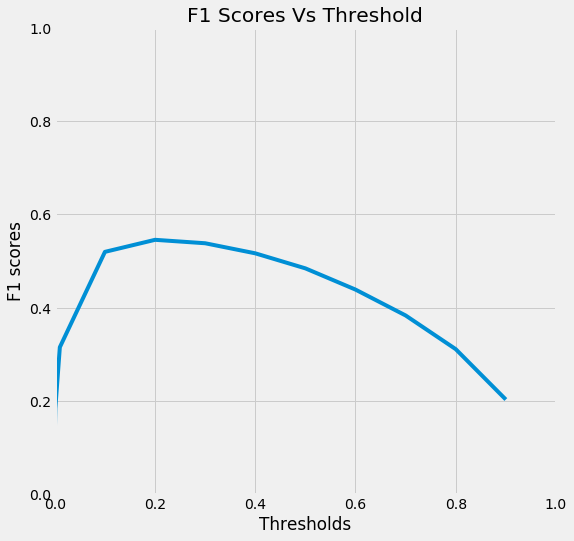

In [71]:
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 8, 8
rcParams['font.size'] = 5
rcParams['axes.facecolor'] = 'white'
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = None
plt.plot(threshold, f1_scores)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('F1 scores')
plt.xlabel('Thresholds')
plt.title('F1 Scores Vs Threshold')
plt.show()

Threshold .2 is giving the best F1 score. Lets take it and predict on X_test and submit it

In [60]:
test_predictions = model.predict(x_test)
y_test_pred = (test_predictions > 0.2).astype(int)

In [61]:
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = y_test_pred
out_df.to_csv("submission.csv", index=False)

In [18]:
import keras.backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
def buildCNN():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, 300, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    
    conv1 = Conv1D(num_filters, kernel_size=(filter_sizes[0]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv2 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv3 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), 
                                 kernel_initializer='he_normal', activation='elu')(x)
    
    maxpool1 = MaxPool1D(pool_size=(maxlen - filter_sizes[0] + 1))(conv1)
    maxpool2 = MaxPool1D(pool_size=(maxlen - filter_sizes[1] + 1))(conv2)
    maxpool3 = MaxPool1D(pool_size=(maxlen - filter_sizes[2] + 1))(conv3)
        
    z = Concatenate(axis=1)([maxpool1, maxpool2, maxpool3])   
    z = Flatten()(z)
    z = BatchNormalization()(z)
        
    output = Dense(1, activation="sigmoid")(z)
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1])

    return model

model1 = buildCNN()
print(model1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 300)      12000000    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 70, 300)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 70, 40)       12040       spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv1d_8 (

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 2048
epochs = 7

early_stopping = EarlyStopping(patience=3, verbose=1, monitor='val_loss', mode='min')
model_checkpoint = ModelCheckpoint('./model1.model1', save_best_only=True, verbose=1, monitor='val_loss', mode='min')
#reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.0001, verbose=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=True)


Instructions for updating:
Use tf.cast instead.
Train on 914285 samples, validate on 391837 samples
Epoch 1/7


417792/914285 [============>.................] - ETA: 52:43 - loss: 0.8958 - acc: 0.48 - ETA: 35:55 - loss: 0.8735 - acc: 0.48 - ETA: 29:27 - loss: 0.8531 - acc: 0.49 - ETA: 25:10 - loss: 0.8347 - acc: 0.50 - ETA: 22:34 - loss: 0.8208 - acc: 0.50 - ETA: 20:50 - loss: 0.8089 - acc: 0.51 - ETA: 19:37 - loss: 0.7997 - acc: 0.52 - ETA: 18:43 - loss: 0.7903 - acc: 0.53 - ETA: 18:14 - loss: 0.7835 - acc: 0.53 - ETA: 18:00 - loss: 0.7764 - acc: 0.54 - ETA: 17:47 - loss: 0.7702 - acc: 0.54 - ETA: 17:38 - loss: 0.7635 - acc: 0.55 - ETA: 17:16 - loss: 0.7578 - acc: 0.55 - ETA: 16:51 - loss: 0.7522 - acc: 0.56 - ETA: 16:46 - loss: 0.7462 - acc: 0.56 - ETA: 16:28 - loss: 0.7411 - acc: 0.56 - ETA: 16:12 - loss: 0.7361 - acc: 0.57 - ETA: 15:54 - loss: 0.7311 - acc: 0.57 - ETA: 15:39 - loss: 0.7261 - acc: 0.58 - ETA: 15:28 - loss: 0.7216 - acc: 0.58 - ETA: 15:17 - loss: 0.7174 - acc: 0.58 - ETA: 15:09 - loss: 0.7128 - acc: 0.59 - ETA: 15:00 - loss: 0.7083 - acc: 0.59 - ETA: 14:56 - loss: 0.7043 - acc

835584/914285 [==========================>...] - ETA: 9:05 - loss: 0.3481 - acc: 0.860 - ETA: 9:03 - loss: 0.3472 - acc: 0.860 - ETA: 9:01 - loss: 0.3464 - acc: 0.861 - ETA: 8:58 - loss: 0.3456 - acc: 0.861 - ETA: 8:56 - loss: 0.3447 - acc: 0.861 - ETA: 8:54 - loss: 0.3439 - acc: 0.862 - ETA: 8:51 - loss: 0.3430 - acc: 0.862 - ETA: 8:49 - loss: 0.3422 - acc: 0.863 - ETA: 8:47 - loss: 0.3414 - acc: 0.863 - ETA: 8:45 - loss: 0.3405 - acc: 0.863 - ETA: 8:42 - loss: 0.3397 - acc: 0.864 - ETA: 8:40 - loss: 0.3390 - acc: 0.864 - ETA: 8:38 - loss: 0.3383 - acc: 0.864 - ETA: 8:36 - loss: 0.3375 - acc: 0.865 - ETA: 8:33 - loss: 0.3367 - acc: 0.865 - ETA: 8:31 - loss: 0.3359 - acc: 0.866 - ETA: 8:29 - loss: 0.3351 - acc: 0.866 - ETA: 8:27 - loss: 0.3343 - acc: 0.866 - ETA: 8:25 - loss: 0.3336 - acc: 0.867 - ETA: 8:22 - loss: 0.3329 - acc: 0.867 - ETA: 8:20 - loss: 0.3322 - acc: 0.867 - ETA: 8:18 - loss: 0.3314 - acc: 0.868 - ETA: 8:16 - loss: 0.3307 - acc: 0.868 - ETA: 8:13 - loss: 0.3299 - acc:

914285/914285 [==============================] - ETA: 1:25 - loss: 0.2544 - acc: 0.901 - ETA: 1:22 - loss: 0.2542 - acc: 0.901 - ETA: 1:20 - loss: 0.2540 - acc: 0.902 - ETA: 1:18 - loss: 0.2537 - acc: 0.902 - ETA: 1:15 - loss: 0.2535 - acc: 0.902 - ETA: 1:13 - loss: 0.2532 - acc: 0.902 - ETA: 1:11 - loss: 0.2531 - acc: 0.902 - ETA: 1:09 - loss: 0.2528 - acc: 0.902 - ETA: 1:06 - loss: 0.2526 - acc: 0.902 - ETA: 1:04 - loss: 0.2524 - acc: 0.902 - ETA: 1:02 - loss: 0.2521 - acc: 0.902 - ETA: 1:00 - loss: 0.2519 - acc: 0.902 - ETA: 57s - loss: 0.2517 - acc: 0.903 - ETA: 55s - loss: 0.2515 - acc: 0.90 - ETA: 53s - loss: 0.2513 - acc: 0.90 - ETA: 50s - loss: 0.2511 - acc: 0.90 - ETA: 48s - loss: 0.2509 - acc: 0.90 - ETA: 46s - loss: 0.2507 - acc: 0.90 - ETA: 44s - loss: 0.2505 - acc: 0.90 - ETA: 41s - loss: 0.2502 - acc: 0.90 - ETA: 39s - loss: 0.2500 - acc: 0.90 - ETA: 37s - loss: 0.2498 - acc: 0.90 - ETA: 35s - loss: 0.2496 - acc: 0.90 - ETA: 32s - loss: 0.2494 - acc: 0.90 - ETA: 30s - los

417792/914285 [============>.................] - ETA: 18:16 - loss: 0.1551 - acc: 0.94 - ETA: 17:42 - loss: 0.1515 - acc: 0.94 - ETA: 17:19 - loss: 0.1497 - acc: 0.94 - ETA: 17:03 - loss: 0.1518 - acc: 0.94 - ETA: 16:59 - loss: 0.1494 - acc: 0.94 - ETA: 16:54 - loss: 0.1487 - acc: 0.94 - ETA: 16:50 - loss: 0.1493 - acc: 0.94 - ETA: 16:51 - loss: 0.1514 - acc: 0.94 - ETA: 16:48 - loss: 0.1510 - acc: 0.94 - ETA: 16:45 - loss: 0.1503 - acc: 0.94 - ETA: 16:40 - loss: 0.1495 - acc: 0.94 - ETA: 16:37 - loss: 0.1505 - acc: 0.94 - ETA: 16:32 - loss: 0.1490 - acc: 0.94 - ETA: 16:31 - loss: 0.1490 - acc: 0.94 - ETA: 16:27 - loss: 0.1487 - acc: 0.94 - ETA: 16:26 - loss: 0.1488 - acc: 0.94 - ETA: 16:23 - loss: 0.1487 - acc: 0.94 - ETA: 16:22 - loss: 0.1493 - acc: 0.94 - ETA: 16:20 - loss: 0.1498 - acc: 0.94 - ETA: 16:17 - loss: 0.1482 - acc: 0.94 - ETA: 16:20 - loss: 0.1478 - acc: 0.94 - ETA: 16:17 - loss: 0.1473 - acc: 0.94 - ETA: 16:14 - loss: 0.1474 - acc: 0.94 - ETA: 16:12 - loss: 0.1484 - acc

835584/914285 [==========================>...] - ETA: 8:46 - loss: 0.1459 - acc: 0.946 - ETA: 8:43 - loss: 0.1459 - acc: 0.946 - ETA: 8:41 - loss: 0.1459 - acc: 0.946 - ETA: 8:39 - loss: 0.1458 - acc: 0.946 - ETA: 8:37 - loss: 0.1458 - acc: 0.946 - ETA: 8:35 - loss: 0.1458 - acc: 0.946 - ETA: 8:33 - loss: 0.1457 - acc: 0.946 - ETA: 8:31 - loss: 0.1458 - acc: 0.946 - ETA: 8:29 - loss: 0.1458 - acc: 0.946 - ETA: 8:27 - loss: 0.1458 - acc: 0.946 - ETA: 8:25 - loss: 0.1457 - acc: 0.946 - ETA: 8:23 - loss: 0.1457 - acc: 0.946 - ETA: 8:20 - loss: 0.1457 - acc: 0.946 - ETA: 8:18 - loss: 0.1458 - acc: 0.946 - ETA: 8:16 - loss: 0.1457 - acc: 0.946 - ETA: 8:14 - loss: 0.1457 - acc: 0.946 - ETA: 8:11 - loss: 0.1456 - acc: 0.946 - ETA: 8:09 - loss: 0.1457 - acc: 0.946 - ETA: 8:07 - loss: 0.1457 - acc: 0.946 - ETA: 8:05 - loss: 0.1457 - acc: 0.946 - ETA: 8:03 - loss: 0.1458 - acc: 0.946 - ETA: 8:01 - loss: 0.1458 - acc: 0.946 - ETA: 7:59 - loss: 0.1458 - acc: 0.946 - ETA: 7:57 - loss: 0.1457 - acc:

914285/914285 [==============================] - ETA: 1:22 - loss: 0.1440 - acc: 0.947 - ETA: 1:20 - loss: 0.1440 - acc: 0.947 - ETA: 1:17 - loss: 0.1440 - acc: 0.947 - ETA: 1:15 - loss: 0.1440 - acc: 0.947 - ETA: 1:13 - loss: 0.1439 - acc: 0.947 - ETA: 1:11 - loss: 0.1439 - acc: 0.947 - ETA: 1:09 - loss: 0.1439 - acc: 0.947 - ETA: 1:07 - loss: 0.1438 - acc: 0.947 - ETA: 1:04 - loss: 0.1438 - acc: 0.947 - ETA: 1:02 - loss: 0.1438 - acc: 0.947 - ETA: 1:00 - loss: 0.1438 - acc: 0.947 - ETA: 58s - loss: 0.1438 - acc: 0.947 - ETA: 56s - loss: 0.1437 - acc: 0.94 - ETA: 53s - loss: 0.1437 - acc: 0.94 - ETA: 51s - loss: 0.1437 - acc: 0.94 - ETA: 49s - loss: 0.1438 - acc: 0.94 - ETA: 47s - loss: 0.1438 - acc: 0.94 - ETA: 45s - loss: 0.1438 - acc: 0.94 - ETA: 42s - loss: 0.1438 - acc: 0.94 - ETA: 40s - loss: 0.1438 - acc: 0.94 - ETA: 38s - loss: 0.1438 - acc: 0.94 - ETA: 36s - loss: 0.1438 - acc: 0.94 - ETA: 34s - loss: 0.1437 - acc: 0.94 - ETA: 31s - loss: 0.1437 - acc: 0.94 - ETA: 29s - loss:

417792/914285 [============>.................] - ETA: 16:50 - loss: 0.1299 - acc: 0.95 - ETA: 16:58 - loss: 0.1223 - acc: 0.95 - ETA: 17:09 - loss: 0.1241 - acc: 0.95 - ETA: 17:03 - loss: 0.1319 - acc: 0.95 - ETA: 16:50 - loss: 0.1359 - acc: 0.94 - ETA: 16:14 - loss: 0.1341 - acc: 0.95 - ETA: 16:15 - loss: 0.1348 - acc: 0.94 - ETA: 16:13 - loss: 0.1363 - acc: 0.94 - ETA: 16:16 - loss: 0.1354 - acc: 0.94 - ETA: 16:21 - loss: 0.1360 - acc: 0.94 - ETA: 16:21 - loss: 0.1358 - acc: 0.94 - ETA: 16:18 - loss: 0.1350 - acc: 0.94 - ETA: 16:20 - loss: 0.1354 - acc: 0.94 - ETA: 16:16 - loss: 0.1357 - acc: 0.94 - ETA: 16:14 - loss: 0.1350 - acc: 0.94 - ETA: 16:09 - loss: 0.1355 - acc: 0.94 - ETA: 16:07 - loss: 0.1347 - acc: 0.94 - ETA: 16:03 - loss: 0.1347 - acc: 0.94 - ETA: 16:00 - loss: 0.1340 - acc: 0.94 - ETA: 15:58 - loss: 0.1344 - acc: 0.94 - ETA: 15:54 - loss: 0.1342 - acc: 0.94 - ETA: 15:50 - loss: 0.1345 - acc: 0.94 - ETA: 15:48 - loss: 0.1344 - acc: 0.94 - ETA: 15:44 - loss: 0.1348 - acc

835584/914285 [==========================>...] - ETA: 9:14 - loss: 0.1347 - acc: 0.949 - ETA: 9:11 - loss: 0.1347 - acc: 0.949 - ETA: 9:09 - loss: 0.1348 - acc: 0.949 - ETA: 9:07 - loss: 0.1348 - acc: 0.949 - ETA: 9:04 - loss: 0.1348 - acc: 0.949 - ETA: 9:02 - loss: 0.1347 - acc: 0.949 - ETA: 9:00 - loss: 0.1347 - acc: 0.949 - ETA: 8:58 - loss: 0.1347 - acc: 0.949 - ETA: 8:55 - loss: 0.1347 - acc: 0.949 - ETA: 8:53 - loss: 0.1346 - acc: 0.949 - ETA: 8:51 - loss: 0.1346 - acc: 0.949 - ETA: 8:49 - loss: 0.1346 - acc: 0.949 - ETA: 8:46 - loss: 0.1346 - acc: 0.949 - ETA: 8:44 - loss: 0.1346 - acc: 0.949 - ETA: 8:42 - loss: 0.1346 - acc: 0.949 - ETA: 8:39 - loss: 0.1346 - acc: 0.949 - ETA: 8:37 - loss: 0.1346 - acc: 0.949 - ETA: 8:35 - loss: 0.1346 - acc: 0.949 - ETA: 8:32 - loss: 0.1346 - acc: 0.949 - ETA: 8:30 - loss: 0.1347 - acc: 0.949 - ETA: 8:28 - loss: 0.1347 - acc: 0.949 - ETA: 8:26 - loss: 0.1348 - acc: 0.949 - ETA: 8:23 - loss: 0.1348 - acc: 0.949 - ETA: 8:21 - loss: 0.1348 - acc:

914285/914285 [==============================] - ETA: 1:26 - loss: 0.1346 - acc: 0.949 - ETA: 1:23 - loss: 0.1346 - acc: 0.949 - ETA: 1:21 - loss: 0.1346 - acc: 0.949 - ETA: 1:19 - loss: 0.1346 - acc: 0.949 - ETA: 1:16 - loss: 0.1346 - acc: 0.949 - ETA: 1:14 - loss: 0.1346 - acc: 0.949 - ETA: 1:12 - loss: 0.1347 - acc: 0.949 - ETA: 1:09 - loss: 0.1347 - acc: 0.949 - ETA: 1:07 - loss: 0.1347 - acc: 0.949 - ETA: 1:05 - loss: 0.1346 - acc: 0.949 - ETA: 1:03 - loss: 0.1346 - acc: 0.949 - ETA: 1:00 - loss: 0.1346 - acc: 0.949 - ETA: 58s - loss: 0.1345 - acc: 0.949 - ETA: 56s - loss: 0.1345 - acc: 0.94 - ETA: 53s - loss: 0.1345 - acc: 0.94 - ETA: 51s - loss: 0.1346 - acc: 0.94 - ETA: 49s - loss: 0.1346 - acc: 0.94 - ETA: 46s - loss: 0.1346 - acc: 0.94 - ETA: 44s - loss: 0.1346 - acc: 0.94 - ETA: 42s - loss: 0.1346 - acc: 0.94 - ETA: 40s - loss: 0.1346 - acc: 0.94 - ETA: 37s - loss: 0.1346 - acc: 0.94 - ETA: 35s - loss: 0.1345 - acc: 0.94 - ETA: 33s - loss: 0.1346 - acc: 0.94 - ETA: 30s - los

417792/914285 [============>.................] - ETA: 17:24 - loss: 0.1151 - acc: 0.96 - ETA: 17:20 - loss: 0.1182 - acc: 0.96 - ETA: 17:15 - loss: 0.1208 - acc: 0.95 - ETA: 17:15 - loss: 0.1209 - acc: 0.95 - ETA: 17:18 - loss: 0.1245 - acc: 0.95 - ETA: 17:12 - loss: 0.1235 - acc: 0.95 - ETA: 17:09 - loss: 0.1224 - acc: 0.95 - ETA: 17:01 - loss: 0.1221 - acc: 0.95 - ETA: 16:59 - loss: 0.1236 - acc: 0.95 - ETA: 16:58 - loss: 0.1232 - acc: 0.95 - ETA: 16:55 - loss: 0.1229 - acc: 0.95 - ETA: 16:52 - loss: 0.1239 - acc: 0.95 - ETA: 16:47 - loss: 0.1244 - acc: 0.95 - ETA: 16:44 - loss: 0.1231 - acc: 0.95 - ETA: 16:40 - loss: 0.1244 - acc: 0.95 - ETA: 16:36 - loss: 0.1241 - acc: 0.95 - ETA: 16:34 - loss: 0.1240 - acc: 0.95 - ETA: 16:30 - loss: 0.1254 - acc: 0.95 - ETA: 16:27 - loss: 0.1251 - acc: 0.95 - ETA: 16:23 - loss: 0.1258 - acc: 0.95 - ETA: 16:21 - loss: 0.1259 - acc: 0.95 - ETA: 16:19 - loss: 0.1255 - acc: 0.95 - ETA: 16:16 - loss: 0.1254 - acc: 0.95 - ETA: 16:14 - loss: 0.1257 - acc

835584/914285 [==========================>...] - ETA: 9:14 - loss: 0.1284 - acc: 0.951 - ETA: 9:11 - loss: 0.1284 - acc: 0.951 - ETA: 9:09 - loss: 0.1283 - acc: 0.951 - ETA: 9:07 - loss: 0.1284 - acc: 0.951 - ETA: 9:04 - loss: 0.1283 - acc: 0.951 - ETA: 9:02 - loss: 0.1283 - acc: 0.951 - ETA: 9:00 - loss: 0.1283 - acc: 0.951 - ETA: 8:58 - loss: 0.1283 - acc: 0.951 - ETA: 8:55 - loss: 0.1283 - acc: 0.951 - ETA: 8:53 - loss: 0.1282 - acc: 0.951 - ETA: 8:51 - loss: 0.1282 - acc: 0.951 - ETA: 8:48 - loss: 0.1283 - acc: 0.951 - ETA: 8:46 - loss: 0.1284 - acc: 0.951 - ETA: 8:44 - loss: 0.1283 - acc: 0.951 - ETA: 8:41 - loss: 0.1283 - acc: 0.951 - ETA: 8:39 - loss: 0.1283 - acc: 0.951 - ETA: 8:37 - loss: 0.1284 - acc: 0.951 - ETA: 8:34 - loss: 0.1285 - acc: 0.951 - ETA: 8:32 - loss: 0.1285 - acc: 0.951 - ETA: 8:30 - loss: 0.1284 - acc: 0.951 - ETA: 8:28 - loss: 0.1285 - acc: 0.951 - ETA: 8:25 - loss: 0.1285 - acc: 0.951 - ETA: 8:23 - loss: 0.1285 - acc: 0.951 - ETA: 8:21 - loss: 0.1285 - acc:

914285/914285 [==============================] - ETA: 1:25 - loss: 0.1290 - acc: 0.951 - ETA: 1:23 - loss: 0.1289 - acc: 0.951 - ETA: 1:21 - loss: 0.1289 - acc: 0.951 - ETA: 1:18 - loss: 0.1290 - acc: 0.951 - ETA: 1:16 - loss: 0.1290 - acc: 0.951 - ETA: 1:14 - loss: 0.1291 - acc: 0.951 - ETA: 1:12 - loss: 0.1291 - acc: 0.951 - ETA: 1:09 - loss: 0.1291 - acc: 0.951 - ETA: 1:07 - loss: 0.1291 - acc: 0.951 - ETA: 1:05 - loss: 0.1291 - acc: 0.951 - ETA: 1:02 - loss: 0.1291 - acc: 0.951 - ETA: 1:00 - loss: 0.1291 - acc: 0.951 - ETA: 58s - loss: 0.1292 - acc: 0.951 - ETA: 55s - loss: 0.1291 - acc: 0.95 - ETA: 53s - loss: 0.1292 - acc: 0.95 - ETA: 51s - loss: 0.1291 - acc: 0.95 - ETA: 49s - loss: 0.1291 - acc: 0.95 - ETA: 46s - loss: 0.1292 - acc: 0.95 - ETA: 44s - loss: 0.1292 - acc: 0.95 - ETA: 42s - loss: 0.1292 - acc: 0.95 - ETA: 39s - loss: 0.1292 - acc: 0.95 - ETA: 37s - loss: 0.1292 - acc: 0.95 - ETA: 35s - loss: 0.1292 - acc: 0.95 - ETA: 33s - loss: 0.1292 - acc: 0.95 - ETA: 30s - los

417792/914285 [============>.................] - ETA: 18:28 - loss: 0.1308 - acc: 0.95 - ETA: 17:51 - loss: 0.1240 - acc: 0.95 - ETA: 17:31 - loss: 0.1221 - acc: 0.95 - ETA: 17:16 - loss: 0.1224 - acc: 0.95 - ETA: 17:09 - loss: 0.1229 - acc: 0.95 - ETA: 17:04 - loss: 0.1242 - acc: 0.95 - ETA: 16:57 - loss: 0.1244 - acc: 0.95 - ETA: 16:51 - loss: 0.1256 - acc: 0.95 - ETA: 16:51 - loss: 0.1243 - acc: 0.95 - ETA: 16:45 - loss: 0.1250 - acc: 0.95 - ETA: 16:44 - loss: 0.1249 - acc: 0.95 - ETA: 16:42 - loss: 0.1249 - acc: 0.95 - ETA: 16:38 - loss: 0.1249 - acc: 0.95 - ETA: 16:33 - loss: 0.1252 - acc: 0.95 - ETA: 16:33 - loss: 0.1252 - acc: 0.95 - ETA: 16:29 - loss: 0.1243 - acc: 0.95 - ETA: 16:25 - loss: 0.1243 - acc: 0.95 - ETA: 16:22 - loss: 0.1243 - acc: 0.95 - ETA: 16:19 - loss: 0.1240 - acc: 0.95 - ETA: 16:17 - loss: 0.1241 - acc: 0.95 - ETA: 16:14 - loss: 0.1245 - acc: 0.95 - ETA: 16:13 - loss: 0.1247 - acc: 0.95 - ETA: 16:10 - loss: 0.1249 - acc: 0.95 - ETA: 16:08 - loss: 0.1249 - acc

835584/914285 [==========================>...] - ETA: 8:59 - loss: 0.1245 - acc: 0.952 - ETA: 8:56 - loss: 0.1245 - acc: 0.952 - ETA: 8:54 - loss: 0.1245 - acc: 0.952 - ETA: 8:52 - loss: 0.1245 - acc: 0.952 - ETA: 8:50 - loss: 0.1244 - acc: 0.952 - ETA: 8:48 - loss: 0.1245 - acc: 0.952 - ETA: 8:45 - loss: 0.1244 - acc: 0.952 - ETA: 8:43 - loss: 0.1243 - acc: 0.952 - ETA: 8:41 - loss: 0.1243 - acc: 0.952 - ETA: 8:39 - loss: 0.1243 - acc: 0.952 - ETA: 8:36 - loss: 0.1243 - acc: 0.952 - ETA: 8:34 - loss: 0.1242 - acc: 0.952 - ETA: 8:32 - loss: 0.1243 - acc: 0.952 - ETA: 8:30 - loss: 0.1242 - acc: 0.952 - ETA: 8:27 - loss: 0.1243 - acc: 0.952 - ETA: 8:25 - loss: 0.1243 - acc: 0.952 - ETA: 8:23 - loss: 0.1243 - acc: 0.952 - ETA: 8:20 - loss: 0.1244 - acc: 0.952 - ETA: 8:18 - loss: 0.1243 - acc: 0.952 - ETA: 8:16 - loss: 0.1243 - acc: 0.952 - ETA: 8:14 - loss: 0.1243 - acc: 0.952 - ETA: 8:12 - loss: 0.1243 - acc: 0.952 - ETA: 8:09 - loss: 0.1244 - acc: 0.952 - ETA: 8:07 - loss: 0.1244 - acc:

914285/914285 [==============================] - ETA: 1:23 - loss: 0.1244 - acc: 0.952 - ETA: 1:21 - loss: 0.1245 - acc: 0.952 - ETA: 1:19 - loss: 0.1244 - acc: 0.952 - ETA: 1:17 - loss: 0.1244 - acc: 0.952 - ETA: 1:14 - loss: 0.1244 - acc: 0.952 - ETA: 1:12 - loss: 0.1244 - acc: 0.952 - ETA: 1:10 - loss: 0.1244 - acc: 0.952 - ETA: 1:08 - loss: 0.1244 - acc: 0.952 - ETA: 1:05 - loss: 0.1244 - acc: 0.952 - ETA: 1:03 - loss: 0.1244 - acc: 0.952 - ETA: 1:01 - loss: 0.1243 - acc: 0.952 - ETA: 59s - loss: 0.1244 - acc: 0.952 - ETA: 56s - loss: 0.1244 - acc: 0.95 - ETA: 54s - loss: 0.1244 - acc: 0.95 - ETA: 52s - loss: 0.1244 - acc: 0.95 - ETA: 50s - loss: 0.1244 - acc: 0.95 - ETA: 48s - loss: 0.1244 - acc: 0.95 - ETA: 45s - loss: 0.1244 - acc: 0.95 - ETA: 43s - loss: 0.1244 - acc: 0.95 - ETA: 41s - loss: 0.1244 - acc: 0.95 - ETA: 39s - loss: 0.1245 - acc: 0.95 - ETA: 36s - loss: 0.1244 - acc: 0.95 - ETA: 34s - loss: 0.1245 - acc: 0.95 - ETA: 32s - loss: 0.1245 - acc: 0.95 - ETA: 30s - loss:

417792/914285 [============>.................] - ETA: 17:49 - loss: 0.1461 - acc: 0.94 - ETA: 17:38 - loss: 0.1326 - acc: 0.94 - ETA: 17:36 - loss: 0.1270 - acc: 0.95 - ETA: 17:36 - loss: 0.1264 - acc: 0.95 - ETA: 17:46 - loss: 0.1242 - acc: 0.95 - ETA: 17:46 - loss: 0.1241 - acc: 0.95 - ETA: 17:59 - loss: 0.1220 - acc: 0.95 - ETA: 17:54 - loss: 0.1202 - acc: 0.95 - ETA: 17:57 - loss: 0.1203 - acc: 0.95 - ETA: 17:53 - loss: 0.1199 - acc: 0.95 - ETA: 17:48 - loss: 0.1190 - acc: 0.95 - ETA: 17:40 - loss: 0.1190 - acc: 0.95 - ETA: 17:34 - loss: 0.1189 - acc: 0.95 - ETA: 17:27 - loss: 0.1182 - acc: 0.95 - ETA: 17:23 - loss: 0.1179 - acc: 0.95 - ETA: 17:26 - loss: 0.1188 - acc: 0.95 - ETA: 17:23 - loss: 0.1187 - acc: 0.95 - ETA: 17:21 - loss: 0.1192 - acc: 0.95 - ETA: 17:16 - loss: 0.1189 - acc: 0.95 - ETA: 17:14 - loss: 0.1191 - acc: 0.95 - ETA: 17:12 - loss: 0.1187 - acc: 0.95 - ETA: 17:10 - loss: 0.1186 - acc: 0.95 - ETA: 17:05 - loss: 0.1184 - acc: 0.95 - ETA: 17:02 - loss: 0.1188 - acc

835584/914285 [==========================>...] - ETA: 9:40 - loss: 0.1196 - acc: 0.954 - ETA: 9:38 - loss: 0.1196 - acc: 0.954 - ETA: 9:36 - loss: 0.1196 - acc: 0.954 - ETA: 9:33 - loss: 0.1196 - acc: 0.954 - ETA: 9:31 - loss: 0.1196 - acc: 0.954 - ETA: 9:28 - loss: 0.1196 - acc: 0.954 - ETA: 9:26 - loss: 0.1196 - acc: 0.954 - ETA: 9:23 - loss: 0.1196 - acc: 0.954 - ETA: 9:21 - loss: 0.1197 - acc: 0.954 - ETA: 9:18 - loss: 0.1196 - acc: 0.954 - ETA: 9:16 - loss: 0.1196 - acc: 0.954 - ETA: 9:14 - loss: 0.1195 - acc: 0.954 - ETA: 9:11 - loss: 0.1196 - acc: 0.954 - ETA: 9:09 - loss: 0.1196 - acc: 0.954 - ETA: 9:06 - loss: 0.1196 - acc: 0.954 - ETA: 9:04 - loss: 0.1196 - acc: 0.954 - ETA: 9:01 - loss: 0.1196 - acc: 0.954 - ETA: 8:59 - loss: 0.1197 - acc: 0.954 - ETA: 8:57 - loss: 0.1197 - acc: 0.954 - ETA: 8:54 - loss: 0.1197 - acc: 0.954 - ETA: 8:52 - loss: 0.1198 - acc: 0.954 - ETA: 8:49 - loss: 0.1198 - acc: 0.954 - ETA: 8:47 - loss: 0.1198 - acc: 0.954 - ETA: 8:44 - loss: 0.1198 - acc:

914285/914285 [==============================] - ETA: 1:20 - loss: 0.1206 - acc: 0.954 - ETA: 1:18 - loss: 0.1206 - acc: 0.954 - ETA: 1:15 - loss: 0.1206 - acc: 0.954 - ETA: 1:13 - loss: 0.1207 - acc: 0.954 - ETA: 1:11 - loss: 0.1206 - acc: 0.954 - ETA: 1:09 - loss: 0.1207 - acc: 0.954 - ETA: 1:07 - loss: 0.1207 - acc: 0.954 - ETA: 1:05 - loss: 0.1206 - acc: 0.954 - ETA: 1:02 - loss: 0.1206 - acc: 0.954 - ETA: 1:00 - loss: 0.1206 - acc: 0.954 - ETA: 58s - loss: 0.1206 - acc: 0.954 - ETA: 56s - loss: 0.1206 - acc: 0.95 - ETA: 54s - loss: 0.1206 - acc: 0.95 - ETA: 52s - loss: 0.1206 - acc: 0.95 - ETA: 49s - loss: 0.1206 - acc: 0.95 - ETA: 47s - loss: 0.1206 - acc: 0.95 - ETA: 45s - loss: 0.1207 - acc: 0.95 - ETA: 43s - loss: 0.1207 - acc: 0.95 - ETA: 41s - loss: 0.1207 - acc: 0.95 - ETA: 39s - loss: 0.1208 - acc: 0.95 - ETA: 36s - loss: 0.1207 - acc: 0.95 - ETA: 34s - loss: 0.1207 - acc: 0.95 - ETA: 32s - loss: 0.1207 - acc: 0.95 - ETA: 30s - loss: 0.1207 - acc: 0.95 - ETA: 28s - loss: 0

417792/914285 [============>.................] - ETA: 12:00 - loss: 0.1231 - acc: 0.94 - ETA: 12:01 - loss: 0.1171 - acc: 0.95 - ETA: 11:52 - loss: 0.1142 - acc: 0.95 - ETA: 12:00 - loss: 0.1120 - acc: 0.95 - ETA: 11:54 - loss: 0.1134 - acc: 0.95 - ETA: 11:46 - loss: 0.1152 - acc: 0.95 - ETA: 11:40 - loss: 0.1144 - acc: 0.95 - ETA: 11:36 - loss: 0.1144 - acc: 0.95 - ETA: 11:33 - loss: 0.1145 - acc: 0.95 - ETA: 11:28 - loss: 0.1162 - acc: 0.95 - ETA: 11:25 - loss: 0.1150 - acc: 0.95 - ETA: 11:24 - loss: 0.1154 - acc: 0.95 - ETA: 11:23 - loss: 0.1147 - acc: 0.95 - ETA: 11:20 - loss: 0.1144 - acc: 0.95 - ETA: 11:16 - loss: 0.1138 - acc: 0.95 - ETA: 11:16 - loss: 0.1136 - acc: 0.95 - ETA: 11:14 - loss: 0.1135 - acc: 0.95 - ETA: 11:12 - loss: 0.1129 - acc: 0.95 - ETA: 11:10 - loss: 0.1139 - acc: 0.95 - ETA: 11:06 - loss: 0.1141 - acc: 0.95 - ETA: 11:06 - loss: 0.1153 - acc: 0.95 - ETA: 11:04 - loss: 0.1153 - acc: 0.95 - ETA: 11:03 - loss: 0.1151 - acc: 0.95 - ETA: 11:02 - loss: 0.1148 - acc

835584/914285 [==========================>...] - ETA: 6:20 - loss: 0.1158 - acc: 0.956 - ETA: 6:18 - loss: 0.1158 - acc: 0.956 - ETA: 6:17 - loss: 0.1159 - acc: 0.956 - ETA: 6:15 - loss: 0.1159 - acc: 0.956 - ETA: 6:14 - loss: 0.1159 - acc: 0.956 - ETA: 6:12 - loss: 0.1160 - acc: 0.955 - ETA: 6:10 - loss: 0.1160 - acc: 0.955 - ETA: 6:09 - loss: 0.1160 - acc: 0.955 - ETA: 6:07 - loss: 0.1159 - acc: 0.955 - ETA: 6:06 - loss: 0.1159 - acc: 0.955 - ETA: 6:04 - loss: 0.1159 - acc: 0.955 - ETA: 6:03 - loss: 0.1159 - acc: 0.956 - ETA: 6:01 - loss: 0.1159 - acc: 0.955 - ETA: 5:59 - loss: 0.1159 - acc: 0.955 - ETA: 5:58 - loss: 0.1159 - acc: 0.955 - ETA: 5:56 - loss: 0.1159 - acc: 0.955 - ETA: 5:54 - loss: 0.1159 - acc: 0.956 - ETA: 5:53 - loss: 0.1160 - acc: 0.956 - ETA: 5:51 - loss: 0.1160 - acc: 0.955 - ETA: 5:50 - loss: 0.1160 - acc: 0.955 - ETA: 5:48 - loss: 0.1159 - acc: 0.955 - ETA: 5:46 - loss: 0.1159 - acc: 0.955 - ETA: 5:45 - loss: 0.1159 - acc: 0.955 - ETA: 5:43 - loss: 0.1159 - acc:

914285/914285 [==============================] - ETA: 58s - loss: 0.1167 - acc: 0.955 - ETA: 57s - loss: 0.1167 - acc: 0.95 - ETA: 55s - loss: 0.1167 - acc: 0.95 - ETA: 54s - loss: 0.1167 - acc: 0.95 - ETA: 52s - loss: 0.1166 - acc: 0.95 - ETA: 50s - loss: 0.1167 - acc: 0.95 - ETA: 49s - loss: 0.1167 - acc: 0.95 - ETA: 47s - loss: 0.1167 - acc: 0.95 - ETA: 46s - loss: 0.1167 - acc: 0.95 - ETA: 44s - loss: 0.1167 - acc: 0.95 - ETA: 43s - loss: 0.1167 - acc: 0.95 - ETA: 41s - loss: 0.1167 - acc: 0.95 - ETA: 39s - loss: 0.1167 - acc: 0.95 - ETA: 38s - loss: 0.1166 - acc: 0.95 - ETA: 36s - loss: 0.1166 - acc: 0.95 - ETA: 35s - loss: 0.1166 - acc: 0.95 - ETA: 33s - loss: 0.1166 - acc: 0.95 - ETA: 32s - loss: 0.1166 - acc: 0.95 - ETA: 30s - loss: 0.1167 - acc: 0.95 - ETA: 28s - loss: 0.1166 - acc: 0.95 - ETA: 27s - loss: 0.1166 - acc: 0.95 - ETA: 25s - loss: 0.1166 - acc: 0.95 - ETA: 24s - loss: 0.1166 - acc: 0.95 - ETA: 22s - loss: 0.1166 - acc: 0.95 - ETA: 21s - loss: 0.1166 - acc: 0.95 - 

OSError: Unable to create file (unable to truncate a file which is already open)

In [23]:
# # Pickle epoch_runs to local  computer
#dill: this is necessary in order for pickle to save epoch_runs .
import dill as pickled

save_model2 = open("cnn_model1.pickle", 'wb') #wb= write in bytes. 'Tfidf_LogR.pickle' is the name of the file saved
pickled.dump(model, save_model2) #use pickle to dump the grid1 we trained as 'Tfidf_LogR.pickle' in wb format
save_model2.close() 

In [24]:
# Retrieve the saved file and uplaod it to an object

save_model22 = open("cnn_model1.pickle", 'rb') # rb= read in bytes
model2 = pickled.load(save_model22)
save_model22.close()

# Model Evaluation

In [25]:
import matplotlib.pyplot as plt

def plot_training_and_validation(acc, val_acc, loss, val_loss):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Plot f1-score and training loss of the validation set

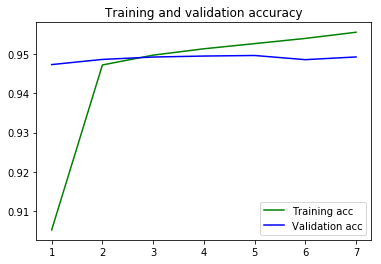

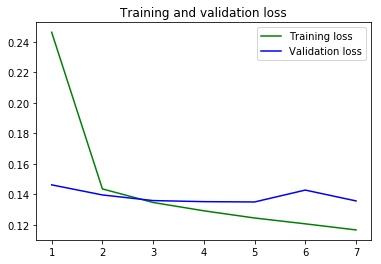

In [28]:
# define plotting metrics
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
# plot model training and validation accuracy and loss
plot_training_and_validation(acc, val_acc, loss, val_loss)

Best fscore is  0.5554287817445712 and optimum Threshold is  0.2308878878878879
F-Score is  0.5554287817445712
Precision score is  0.5019791770615042
recall score is  0.6216171685134078


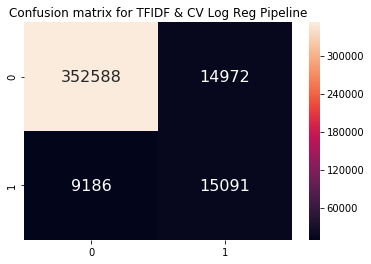

In [34]:
pred = model2.predict(X_val)
fhighest = 0
threbest = 0
thres = np.linspace(.001, .95, 1000)
for t in thres:
    y_pred = (pred > t).astype(int)
    fs = f1_score(y_val, y_pred)
    if fs > fhighest:
        fhighest = fs
        threbest = t
print ("Best fscore is ", fhighest , "and optimum Threshold is ", threbest)

pred1 = (pred > threbest).astype(int)


print ("F-Score is ", f1_score(y_val, pred1))
print("Precision score is " ,precision_score(y_val, pred1) )
print("recall score is " ,recall_score(y_val, pred1) )

conf = confusion_matrix(y_val, pred1)
conf = pd.DataFrame(conf, range(2),range(2))
sns.heatmap(conf, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion matrix for TFIDF & CV Log Reg Pipeline')
plt.show()